In [52]:
#All libraries import here
import torch
import torch.nn as nn
import torch.optim as optim
import requests
import json
import pandas as pd
import datetime as dt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

import ray
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro, normaltest, jarque_bera
from hurst import compute_Hc
from functools import partial
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import normaltest

## 1. Data loading

In [54]:
df = pd.read_csv('BTCUSDT_daily.csv')
# Make a copy of the DataFrame to avoid SettingWithCopyWarning
df_copy = df.copy()

# ---------- 1. Calculate Technical Indicators ----------

# Log Returns
df_copy['LogReturns'] = np.log(df_copy['Close'] / df_copy['Close'].shift(1))

# Parkinson Volatility
df_copy['Volatility'] = (np.log(df_copy['High']) - np.log(df_copy['Low'])) ** 2 / (4 * np.log(2))

# back 14-day SMA and EMA
df_copy['SMA_14'] = df_copy['Close'].rolling(window=14).mean()
# 14-day RSI
delta = df_copy['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df_copy['RSI_14'] = 100 - (100 / (1 + rs))

# OBV
obv = [0]
for i in range(1, len(df_copy)):
    if df_copy['Close'].iloc[i] > df_copy['Close'].iloc[i - 1]:
        obv.append(obv[-1] + df_copy['Volume'].iloc[i])
    elif df_copy['Close'].iloc[i] < df_copy['Close'].iloc[i - 1]:
        obv.append(obv[-1] - df_copy['Volume'].iloc[i])
    else:
        obv.append(obv[-1])
df_copy['OBV'] = obv

# ATR (14-day)
high_low = df_copy['High'] - df_copy['Low']
high_close = np.abs(df_copy['High'] - df_copy['Close'].shift(1))
low_close = np.abs(df_copy['Low'] - df_copy['Close'].shift(1))
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df_copy['ATR_14'] = tr.rolling(window=14).mean()

# Drop rows with NaNs from rolling windows
df_copy = df_copy.dropna()

# ---------- 2. Normalize All 8 Features ----------
features_to_scale = ['LogReturns', 'Volume', 'Volatility', 'SMA_14', 'RSI_14', 'OBV', 'ATR_14']
scaler = MinMaxScaler(feature_range=(0, 1))

for feature in features_to_scale:
    df_copy.loc[:, f'{feature}_Norm'] = scaler.fit_transform(df_copy[feature].values.reshape(-1, 1)).flatten()

# ---------- 3. Create Sequences Using the Normalised Features ----------
def create_multifeature_sequences(data, feature_columns, seq_length=3):
    # Pre-allocate arrays
    n_samples = len(data) - seq_length
    n_features = len(feature_columns)
    X = np.zeros((n_samples, seq_length, n_features), dtype=np.float32)
    y = np.zeros(n_samples, dtype=np.float32)
    
    for i in range(n_samples):
        # Build the sequence for each sample
        for j in range(seq_length):
            X[i, j, :] = data.iloc[i + j][feature_columns].values
        # Target is the next raw LogReturns value
        y[i] = data.iloc[i + seq_length]['LogReturns']
    
    return X, y

# Use all 8 normalized features
feature_columns = ['LogReturns_Norm', 'Volume_Norm', 'Volatility_Norm'
                   ,'SMA_14_Norm'
                   #, 'EMA_14_Norm'
                   , 'RSI_14_Norm'
                   , 'OBV_Norm'
                   , 'ATR_14_Norm'
                  ]


X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)
df_copy

,Date,Open,High,Low,Close,Volume,LogReturns,Volatility,SMA_14,RSI_14,OBV,ATR_14,LogReturns_Norm,Volume_Norm,Volatility_Norm,SMA_14_Norm,RSI_14_Norm,OBV_Norm,ATR_14_Norm
14,2018-01-15 11:00:00,13477.98,14249.99,13147.79,13539.93,14652.094705,0.004808,0.002337,14803.407857,50.775896,55856.767179,1860.680000,0.745042,0.017583,0.018501,0.113630,0.484936,0.475056,0.294187
15,2018-01-16 11:00:00,13500.00,13542.93,9035.00,10900.00,63401.169175,-0.216880,0.059089,14533.757143,33.799160,-7544.401996,1998.141429,0.419535,0.081777,0.468509,0.110938,0.305204,0.468014,0.316867
16,2018-01-17 11:00:00,10899.99,11680.99,9037.94,10988.79,72331.796646,0.008113,0.023735,14252.991429,32.903015,64787.394650,2104.247857,0.749895,0.093537,0.188175,0.108135,0.295717,0.476048,0.334373
17,2018-01-18 11:00:00,10972.59,11878.82,10435.33,10961.97,48464.434937,-0.002444,0.006054,13960.307857,32.000018,16322.959713,2110.071429,0.734394,0.062108,0.047973,0.105212,0.286157,0.470665,0.335334
18,2018-01-19 11:00:00,10960.00,11795.00,10360.00,11474.98,34129.375421,0.045737,0.006069,13568.492857,22.557335,50452.335134,2028.554286,0.805138,0.043231,0.048095,0.101300,0.186188,0.474456,0.321884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642,2025-03-27 11:00:00,86909.17,87756.39,85800.00,87232.01,17098.038970,0.003708,0.000183,85123.903571,65.745032,-814330.499400,2634.332857,0.743427,0.020804,0.001421,0.815742,0.643414,0.378403,0.421831
2643,2025-03-28 11:00:00,87232.01,87515.67,83585.00,84424.38,27182.731690,-0.032715,0.000762,85155.416429,51.139238,-841513.231090,2594.318571,0.689946,0.034083,0.006007,0.816056,0.488783,0.375384,0.415229
2644,2025-03-29 11:00:00,84424.38,84624.73,81644.81,82648.54,11696.398640,-0.021259,0.000464,85034.709286,45.934523,-853209.629730,2731.578571,0.706767,0.013691,0.003642,0.814851,0.433681,0.374084,0.437875
2645,2025-03-30 11:00:00,82648.53,83534.64,81565.00,82389.99,9864.495080,-0.003133,0.000205,85021.527857,49.521376,-863074.124810,2648.272857,0.733382,0.011278,0.001595,0.814720,0.471655,0.372989,0.424131


## 2. Modelling - one run before tuning

## 3. Hyperparameter tuning

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import random
import json
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 0. Set All Seeds
# -------------------------
def set_all_seeds(seed=2025):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

set_all_seeds(2025)

# -------------------------
# 1. Data Preparation
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets"""
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Split and convert to tensors
    X_train = torch.FloatTensor(X_all[:train_end]).to(device)
    y_train = torch.FloatTensor(y_all[:train_end]).unsqueeze(1).to(device)
    X_val = torch.FloatTensor(X_all[train_end:val_end]).to(device)
    y_val = torch.FloatTensor(y_all[train_end:val_end]).unsqueeze(1).to(device)
    X_test = torch.FloatTensor(X_all[val_end:]).to(device)
    y_test = torch.FloatTensor(y_all[val_end:]).unsqueeze(1).to(device)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 2. Model Definition with Built-in LayerNorm
# -------------------------
class AsymmetricLaplaceQuantile(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # LayerNorm after LSTM (always on)
        self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # LayerNorm for hidden layers (always on, except for last layer)
            if i < n_hidden_layers - 1:
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM
        last_hidden = self.lstm_layer_norm(last_hidden)
        
        return self.fc(last_hidden)

# -------------------------
# 3. CORRECTED Loss Functions based on ALD density
# -------------------------
def ald_loss(y, mu, alpha, sigma=1.0):

    error = y - mu
    check = torch.where(error > 0, alpha * error, (alpha - 1) * error)
    
    # Full negative log-likelihood
    nll = -torch.log(torch.tensor(alpha * (1 - alpha), device=y.device)) + \
          torch.log(torch.tensor(sigma, device=y.device)) + \
          check / sigma
    
    return nll.mean()

def calculate_nll(y_true, y_pred, alpha, sigma=1.0):
    """
    Calculate ALD negative log-likelihood for evaluation.
    Uses the same formula as the training loss for consistency.
    """
    if not torch.is_tensor(y_true):
        y_true = torch.FloatTensor(y_true)
        y_pred = torch.FloatTensor(y_pred)
    
    error = y_true - y_pred
    
    # Using the same logic as training loss
    check = torch.where(error > 0, alpha * error, (alpha - 1) * error)
    
    nll = -torch.log(torch.tensor(alpha * (1 - alpha))) + \
          torch.log(torch.tensor(sigma)) + \
          check / sigma
    
    return nll.mean().item()


# -------------------------
# 4. Training Function with Built-in LR Scheduler
# -------------------------
def train_single_seed(X_train, y_train, X_val, y_val, config, seed):
    """Train model with a specific seed and return validation NLL"""
    set_all_seeds(seed)
    
    model = AsymmetricLaplaceQuantile(config).to(X_train.device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))
    if config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler (always on with fixed parameters)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=20,  # Fixed
        factor=0.5,   # Fixed
        min_lr=1e-6
    )
    
    # Training setup - FASTER SETTINGS
    batch_size = config.get('batch_size', 64)
    epochs = 200  # Faster setting
    patience = 20  # Faster setting
    best_val_nll = float('inf')
    patience_counter = 0
    best_model_state = None
    
    sigma = config.get('sigma', 1.0)
    alpha = config['tau']  # Note: using 'tau' key but treating as alpha
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    generator = torch.Generator().manual_seed(seed)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)
    
    for epoch in range(epochs):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = ald_loss(batch_y, pred, alpha, sigma)  # Use corrected loss
            loss.backward()
            
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_nll = calculate_nll(y_val, val_pred, alpha, sigma)
        
        # Update learning rate
        scheduler.step(val_nll)
        
        # Early stopping
        if val_nll < best_val_nll:
            best_val_nll = val_nll
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    # Load best model if available
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return best_val_nll

def train_for_hp_search(X_train, y_train, X_val, y_val, config, trial=None):
    """Train with multiple seeds and return mean NLL"""
    seeds = [2025, 2125]  # Reduced to 2 seeds for faster training
    val_nlls = []
    
    for i, seed in enumerate(seeds):
        try:
            val_nll = train_single_seed(X_train, y_train, X_val, y_val, config, seed)
            val_nlls.append(val_nll)
            
            if trial and i < len(seeds) - 1:
                trial.report(np.mean(val_nlls), i)
                if trial.should_prune():
                    raise optuna.TrialPruned()
        except Exception as e:
            print(f"Failed with seed {seed}: {e}")
            continue
    
    return np.mean(val_nlls) if val_nlls else float('inf')

# -------------------------
# 5. Hyperparameter Search Space (without LayerNorm/BatchNorm options)
# -------------------------
def get_hp_space(tau, trial):
    """
    Two-condition hyperparameter space without normalization options
    """
    base = {'tau': tau}
    is_extreme = (tau <= 0.05) or (tau >= 0.95)

    if is_extreme:
        # Extremes: smaller-capacity band
        base.update({
            'lstm_hidden_dim': trial.suggest_int('lstm_hidden_dim', 16, 128),
            'lstm_layers':     trial.suggest_int('lstm_layers', 1, 2),
            'n_hidden_layers': 2,
            'n_hidden1':       trial.suggest_int('n_hidden1', 16, 128),
            'n_hidden2':       trial.suggest_int('n_hidden2', 16, 128),
            'activation':      trial.suggest_categorical('activation', ['relu', 'elu','gelu']),
            'dropout':         trial.suggest_float('dropout', 0.00, 0.15),
            'weight_decay':    trial.suggest_float('weight_decay', 0.0, 1e-4),
            'optimizer':       trial.suggest_categorical('optimizer', ['adam', 'adamw']),
            'lr':              trial.suggest_float('lr', 1e-4, 1e-2, log=True),
            'batch_size':      trial.suggest_int('batch_size', 16, 128),
            'weight_init':     trial.suggest_categorical('weight_init', ['glorot_normal', 'glorot_uniform', 'he_normal']),
            'sigma':           trial.suggest_float('sigma', 0.3, 1.2),
        })
    else:
        # Central: higher-capacity band
        base.update({
            'lstm_hidden_dim': trial.suggest_int('lstm_hidden_dim', 48, 128),
            'lstm_layers':     trial.suggest_int('lstm_layers', 1, 2),
            'n_hidden_layers': 2,
            'n_hidden1':       trial.suggest_int('n_hidden1', 48, 128),
            'n_hidden2':       trial.suggest_int('n_hidden2', 48, 128),
            'activation':      trial.suggest_categorical('activation', ['relu', 'elu', 'gelu']),
            'dropout':         trial.suggest_float('dropout', 0.00, 0.15),
            'weight_decay':    trial.suggest_float('weight_decay', 0.0, 3e-4),
            'optimizer':       trial.suggest_categorical('optimizer', ['adam', 'adamw']),
            'lr':              trial.suggest_float('lr', 1e-4, 2e-2, log=True),
            'batch_size':      trial.suggest_int('batch_size', 16, 128),
            'weight_init':     trial.suggest_categorical('weight_init', ['glorot_normal', 'glorot_uniform', 'he_normal']),
            'sigma':           trial.suggest_float('sigma', 0.3, 1.2),
        })

    # Optional gradient clipping
    use_gc = trial.suggest_categorical('use_gradient_clip', [False, True])
    base['gradient_clip'] = trial.suggest_float('gradient_clip_value', 0.5, 8.0) if use_gc else None

    return base

def tune_hyperparameters(X_train, y_train, X_val, y_val, tau, n_trials=20):
    """Tune hyperparameters for a specific quantile"""
    print(f"\n{'='*60}")
    print(f"Tuning Hyperparameters for α={tau:.3f}")
    print(f"Built-in: LayerNorm ON | LR Scheduler ON (patience=20, factor=0.5)")
    print(f"Training: epochs=200, patience=20")
    print(f"Seeds: 2 | Trials: {n_trials}")
    print(f"Scoring: 100% Validation NLL")
    print(f"Using corrected ALD loss based on density formula")
    print(f"{'='*60}")
    
    input_dim = X_train.shape[2]
    
    def objective(trial):
        config = get_hp_space(tau, trial)
        config['input_dim'] = input_dim
        
        # Store config for retrieval
        for key, value in config.items():
            trial.set_user_attr(f'config_{key}', value)
        
        return train_for_hp_search(X_train, y_train, X_val, y_val, config, trial)
    
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=2025),#2015
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=3)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Reconstruct best config
    best_config = {}
    for attr_name, attr_value in study.best_trial.user_attrs.items():
        if attr_name.startswith('config_'):
            param_name = attr_name.replace('config_', '')
            best_config[param_name] = attr_value
    
    best_config['tau'] = tau
    
    print(f"\nBest NLL: {study.best_value:.4f}")
    print("Best parameters:")
    for k, v in sorted(best_config.items()):
        if k not in ['input_dim', 'tau']:
            print(f"  {k}: {v}")
    
    return best_config

# -------------------------
# 6. Main Pipeline
# -------------------------
def main(X_all, y_all, tau_list=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975], n_trials=20):
    """Main hyperparameter tuning pipeline"""
    import time
    start_time = time.time()
    
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    
    print(f"\nALD HYPERPARAMETER TUNING - CORRECTED LOSS FORMULA")
    print(f"="*60)
    print(f"Data: Train {len(X_train)} | Val {len(X_val)} | Test {len(X_test)}")
    print(f"Training settings: epochs=200, patience=20")
    print(f"Built-in features: LayerNorm (always on) | LR Scheduler (always on)")
    print(f"Loss: Corrected ALD NLL based on density formula")
    print(f"Each config tested with 2 seeds for robustness")
    print(f"Trials per quantile: {n_trials}")
    print(f"Scoring: 100% Validation NLL")
    print(f"{'='*60}")
    
    best_hyperparams = {}
    
    for tau in tau_list:
        tau_start = time.time()
        best_hyperparams[tau] = tune_hyperparameters(X_train, y_train, X_val, y_val, tau, n_trials)
        tau_time = time.time() - tau_start
        print(f"α={tau:.3f} completed in {tau_time/60:.1f} minutes")
    
    # Display results
    display_results(best_hyperparams)
    
    # Save results
    with open('best_hyperparams_ald_corrected.json', 'w') as f:
        json.dump(best_hyperparams, f, indent=2)
    
    total_time = time.time() - start_time
    print(f"\nTotal tuning time: {total_time/60:.1f} minutes")
    
    return best_hyperparams

def display_results(best_hyperparams):
    """Display results in a clean table"""
    param_data = []
    
    for tau in sorted(best_hyperparams.keys()):
        hp = best_hyperparams[tau]
        
        # Handle variable hidden layers
        n_layers = hp.get('n_hidden_layers', 2)
        hidden_dims = '-'.join([str(hp.get(f'n_hidden{i}', 'N/A')) for i in range(1, n_layers + 1)])
        
        param_data.append({
            'α': f"{tau:.3f}",
            'LSTM': f"{hp.get('lstm_hidden_dim')}×{hp.get('lstm_layers', 1)}",
            'Hidden': hidden_dims,
            'Act': hp.get('activation', 'relu')[:4],
            'Opt': hp.get('optimizer', 'adam')[:4],
            'LR': f"{hp.get('lr'):.4f}",
            'Drop': f"{hp.get('dropout'):.3f}",
            'Batch': hp.get('batch_size'),
            'σ': f"{hp.get('sigma'):.3f}",
            'WD': f"{hp.get('weight_decay', 0):.0e}",
            'Clip': hp.get('gradient_clip', '-'),
            'Init': hp.get('weight_init', 'glorot')[:6]
        })
    
    df = pd.DataFrame(param_data)
    
    print("\n" + "="*120)
    print("ALD HYPERPARAMETER TUNING RESULTS - CORRECTED LOSS FORMULA")
    print("="*120)
    print(df.to_string(index=False))
    print("="*120)
    print("Note: LayerNorm and LR Scheduler are always enabled (not tuned)")
    print("Loss function uses corrected ALD density formula")
    print("="*120)
    
    df.to_csv('ald_hp_results_corrected.csv', index=False)
    
    return df

# -------------------------
# 7. Usage
# -------------------------
if __name__ == "__main__":
    # Assuming X_all and y_all are defined elsewhere
    best_hyperparams = main(X_all, y_all, n_trials=20)

[I 2025-08-29 11:47:35,313] A new study created in memory with name: no-name-12b2bd4e-4c15-41bd-9abe-b707861e0527


Using device: cpu

ALD HYPERPARAMETER TUNING - CORRECTED LOSS FORMULA
Data: Train 1840 | Val 394 | Test 396
Training settings: epochs=200, patience=20
Built-in features: LayerNorm (always on) | LR Scheduler (always on)
Loss: Corrected ALD NLL based on density formula
Each config tested with 2 seeds for robustness
Trials per quantile: 20
Scoring: 100% Validation NLL

Tuning Hyperparameters for α=0.025
Built-in: LayerNorm ON | LR Scheduler ON (patience=20, factor=0.5)
Training: epochs=200, patience=20
Seeds: 2 | Trials: 20
Scoring: 100% Validation NLL
Using corrected ALD loss based on density formula


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-29 11:47:40,887] Trial 0 finished with value: 3.5533171892166138 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 3.5533171892166138.
[I 2025-08-29 11:47:44,173] Trial 1 finished with value: 3.130004405975342 and parameters: {'lstm_hidden_dim': 44, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 68, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 5.196536887579605e-05, 'optimizer': 'adam', 'lr': 0.0004451295365396247, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 3.130004405975342.
[I 2025-08-29 11:47:46,

[I 2025-08-29 11:48:57,425] A new study created in memory with name: no-name-fd353c1e-74f6-456b-bd42-5867a15e530f


[I 2025-08-29 11:48:57,422] Trial 19 finished with value: 3.059022903442383 and parameters: {'lstm_hidden_dim': 96, 'lstm_layers': 1, 'n_hidden1': 56, 'n_hidden2': 54, 'activation': 'relu', 'dropout': 0.09387678146543642, 'weight_decay': 6.78432508456823e-05, 'optimizer': 'adamw', 'lr': 0.0011316601546662675, 'batch_size': 102, 'weight_init': 'he_normal', 'sigma': 0.5177848087634362, 'use_gradient_clip': True, 'gradient_clip_value': 4.270592472634065}. Best is trial 15 with value: 2.5166980028152466.

Best NLL: 2.5167
Best parameters:
  activation: elu
  batch_size: 85
  dropout: 0.12045225731287629
  gradient_clip: 2.0670970799734083
  lr: 0.004929243678111687
  lstm_hidden_dim: 102
  lstm_layers: 1
  n_hidden1: 16
  n_hidden2: 41
  n_hidden_layers: 2
  optimizer: adamw
  sigma: 0.30016696782230184
  weight_decay: 5.261534602609984e-05
  weight_init: glorot_normal
α=0.025 completed in 1.4 minutes

Tuning Hyperparameters for α=0.050
Built-in: LayerNorm ON | LR Scheduler ON (patience=20

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-29 11:49:04,561] Trial 0 finished with value: 2.8873642683029175 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 2.8873642683029175.
[I 2025-08-29 11:49:07,793] Trial 1 finished with value: 2.465047001838684 and parameters: {'lstm_hidden_dim': 44, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 68, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 5.196536887579605e-05, 'optimizer': 'adam', 'lr': 0.0004451295365396247, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 2.465047001838684.
[I 2025-08-29 11:49:10,

[I 2025-08-29 11:50:19,142] A new study created in memory with name: no-name-66aaec70-cfa6-48f7-9462-e363e335a28f


[I 2025-08-29 11:50:19,140] Trial 19 finished with value: 2.3941304683685303 and parameters: {'lstm_hidden_dim': 96, 'lstm_layers': 1, 'n_hidden1': 56, 'n_hidden2': 54, 'activation': 'relu', 'dropout': 0.09387678146543642, 'weight_decay': 6.78432508456823e-05, 'optimizer': 'adamw', 'lr': 0.0011316601546662675, 'batch_size': 102, 'weight_init': 'he_normal', 'sigma': 0.5177848087634362, 'use_gradient_clip': True, 'gradient_clip_value': 4.270592472634065}. Best is trial 15 with value: 1.8526152968406677.

Best NLL: 1.8526
Best parameters:
  activation: elu
  batch_size: 85
  dropout: 0.12045225731287629
  gradient_clip: 2.0670970799734083
  lr: 0.004929243678111687
  lstm_hidden_dim: 102
  lstm_layers: 1
  n_hidden1: 16
  n_hidden2: 41
  n_hidden_layers: 2
  optimizer: adamw
  sigma: 0.30016696782230184
  weight_decay: 5.261534602609984e-05
  weight_init: glorot_normal
α=0.050 completed in 1.4 minutes

Tuning Hyperparameters for α=0.250
Built-in: LayerNorm ON | LR Scheduler ON (patience=2

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-29 11:50:30,042] Trial 0 finished with value: 1.51881742477417 and parameters: {'lstm_hidden_dim': 58, 'lstm_layers': 2, 'n_hidden1': 123, 'n_hidden2': 84, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 0.00028927152577501713, 'optimizer': 'adam', 'lr': 0.006970415801044255, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 1.51881742477417.
[I 2025-08-29 11:50:33,245] Trial 1 finished with value: 1.098484218120575 and parameters: {'lstm_hidden_dim': 68, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 85, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 0.00015589610662738814, 'optimizer': 'adam', 'lr': 0.0005573055189230975, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 1.098484218120575.
[I 2025-08-29 11:50:36,03

[I 2025-08-29 11:51:45,075] A new study created in memory with name: no-name-b44fa760-8585-405e-953b-0b4e9d73401f


[I 2025-08-29 11:51:45,073] Trial 19 finished with value: 1.0283828973770142 and parameters: {'lstm_hidden_dim': 92, 'lstm_layers': 1, 'n_hidden1': 107, 'n_hidden2': 59, 'activation': 'relu', 'dropout': 0.09387678146543642, 'weight_decay': 0.0002035297525370469, 'optimizer': 'adamw', 'lr': 0.0016304823052374557, 'batch_size': 102, 'weight_init': 'he_normal', 'sigma': 0.5177848087634362, 'use_gradient_clip': True, 'gradient_clip_value': 4.270592472634065}. Best is trial 15 with value: 0.4919086843729019.

Best NLL: 0.4919
Best parameters:
  activation: elu
  batch_size: 85
  dropout: 0.12045225731287629
  gradient_clip: 2.0670970799734083
  lr: 0.008862762460510171
  lstm_hidden_dim: 87
  lstm_layers: 1
  n_hidden1: 48
  n_hidden2: 66
  n_hidden_layers: 2
  optimizer: adamw
  sigma: 0.30016696782230184
  weight_decay: 0.0001578460380782995
  weight_init: glorot_normal
α=0.250 completed in 1.4 minutes

Tuning Hyperparameters for α=0.500
Built-in: LayerNorm ON | LR Scheduler ON (patience=

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-29 11:51:52,088] Trial 0 finished with value: 1.2328627705574036 and parameters: {'lstm_hidden_dim': 58, 'lstm_layers': 2, 'n_hidden1': 123, 'n_hidden2': 84, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 0.00028927152577501713, 'optimizer': 'adam', 'lr': 0.006970415801044255, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 1.2328627705574036.
[I 2025-08-29 11:51:54,431] Trial 1 finished with value: 0.8131561279296875 and parameters: {'lstm_hidden_dim': 68, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 85, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 0.00015589610662738814, 'optimizer': 'adam', 'lr': 0.0005573055189230975, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 0.8131561279296875.
[I 2025-08-29 11:51

[I 2025-08-29 11:53:22,491] A new study created in memory with name: no-name-81c6fadd-89c3-47a8-9681-8202ed6faa5f


[I 2025-08-29 11:53:22,489] Trial 19 finished with value: 0.7433512806892395 and parameters: {'lstm_hidden_dim': 92, 'lstm_layers': 1, 'n_hidden1': 107, 'n_hidden2': 59, 'activation': 'relu', 'dropout': 0.09387678146543642, 'weight_decay': 0.0002035297525370469, 'optimizer': 'adamw', 'lr': 0.0016304823052374557, 'batch_size': 102, 'weight_init': 'he_normal', 'sigma': 0.5177848087634362, 'use_gradient_clip': True, 'gradient_clip_value': 4.270592472634065}. Best is trial 15 with value: 0.20920142531394958.

Best NLL: 0.2092
Best parameters:
  activation: elu
  batch_size: 85
  dropout: 0.12045225731287629
  gradient_clip: 2.0670970799734083
  lr: 0.008862762460510171
  lstm_hidden_dim: 87
  lstm_layers: 1
  n_hidden1: 48
  n_hidden2: 66
  n_hidden_layers: 2
  optimizer: adamw
  sigma: 0.30016696782230184
  weight_decay: 0.0001578460380782995
  weight_init: glorot_normal
α=0.500 completed in 1.6 minutes

Tuning Hyperparameters for α=0.750
Built-in: LayerNorm ON | LR Scheduler ON (patience

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-29 11:53:32,459] Trial 0 finished with value: 1.5198040008544922 and parameters: {'lstm_hidden_dim': 58, 'lstm_layers': 2, 'n_hidden1': 123, 'n_hidden2': 84, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 0.00028927152577501713, 'optimizer': 'adam', 'lr': 0.006970415801044255, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 1.5198040008544922.
[I 2025-08-29 11:53:36,639] Trial 1 finished with value: 1.099556028842926 and parameters: {'lstm_hidden_dim': 68, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 85, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 0.00015589610662738814, 'optimizer': 'adam', 'lr': 0.0005573055189230975, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 1.099556028842926.
[I 2025-08-29 11:53:3

[I 2025-08-29 11:54:40,537] A new study created in memory with name: no-name-d9b6dd61-f968-4daa-aee5-0a722c3ffaff


[I 2025-08-29 11:54:40,536] Trial 19 finished with value: 1.029765248298645 and parameters: {'lstm_hidden_dim': 92, 'lstm_layers': 1, 'n_hidden1': 107, 'n_hidden2': 59, 'activation': 'relu', 'dropout': 0.09387678146543642, 'weight_decay': 0.0002035297525370469, 'optimizer': 'adamw', 'lr': 0.0016304823052374557, 'batch_size': 102, 'weight_init': 'he_normal', 'sigma': 0.5177848087634362, 'use_gradient_clip': True, 'gradient_clip_value': 4.270592472634065}. Best is trial 15 with value: 0.494746133685112.

Best NLL: 0.4947
Best parameters:
  activation: elu
  batch_size: 85
  dropout: 0.12045225731287629
  gradient_clip: 2.0670970799734083
  lr: 0.008862762460510171
  lstm_hidden_dim: 87
  lstm_layers: 1
  n_hidden1: 48
  n_hidden2: 66
  n_hidden_layers: 2
  optimizer: adamw
  sigma: 0.30016696782230184
  weight_decay: 0.0001578460380782995
  weight_init: glorot_normal
α=0.750 completed in 1.3 minutes

Tuning Hyperparameters for α=0.950
Built-in: LayerNorm ON | LR Scheduler ON (patience=20

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-29 11:54:50,446] Trial 0 finished with value: 2.887915849685669 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 2.887915849685669.
[I 2025-08-29 11:54:53,936] Trial 1 finished with value: 2.4651339054107666 and parameters: {'lstm_hidden_dim': 44, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 68, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 5.196536887579605e-05, 'optimizer': 'adam', 'lr': 0.0004451295365396247, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 2.4651339054107666.
[I 2025-08-29 11:54:57,

[I 2025-08-29 11:56:08,652] A new study created in memory with name: no-name-949e7366-a461-4e48-8f7d-c45d541f68ad


[I 2025-08-29 11:56:08,650] Trial 19 finished with value: 2.3946714401245117 and parameters: {'lstm_hidden_dim': 96, 'lstm_layers': 1, 'n_hidden1': 56, 'n_hidden2': 54, 'activation': 'relu', 'dropout': 0.09387678146543642, 'weight_decay': 6.78432508456823e-05, 'optimizer': 'adamw', 'lr': 0.0011316601546662675, 'batch_size': 102, 'weight_init': 'he_normal', 'sigma': 0.5177848087634362, 'use_gradient_clip': True, 'gradient_clip_value': 4.270592472634065}. Best is trial 15 with value: 1.8538548946380615.

Best NLL: 1.8539
Best parameters:
  activation: elu
  batch_size: 85
  dropout: 0.12045225731287629
  gradient_clip: 2.0670970799734083
  lr: 0.004929243678111687
  lstm_hidden_dim: 102
  lstm_layers: 1
  n_hidden1: 16
  n_hidden2: 41
  n_hidden_layers: 2
  optimizer: adamw
  sigma: 0.30016696782230184
  weight_decay: 5.261534602609984e-05
  weight_init: glorot_normal
α=0.950 completed in 1.5 minutes

Tuning Hyperparameters for α=0.975
Built-in: LayerNorm ON | LR Scheduler ON (patience=2

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-29 11:56:13,638] Trial 0 finished with value: 3.5537209510803223 and parameters: {'lstm_hidden_dim': 31, 'lstm_layers': 2, 'n_hidden1': 121, 'n_hidden2': 66, 'activation': 'gelu', 'dropout': 0.07389254062593936, 'weight_decay': 9.642384192500571e-05, 'optimizer': 'adam', 'lr': 0.004000517487488018, 'batch_size': 20, 'weight_init': 'glorot_normal', 'sigma': 0.8498228994001911, 'use_gradient_clip': False}. Best is trial 0 with value: 3.5537209510803223.
[I 2025-08-29 11:56:17,520] Trial 1 finished with value: 3.1301404237747192 and parameters: {'lstm_hidden_dim': 44, 'lstm_layers': 2, 'n_hidden1': 127, 'n_hidden2': 68, 'activation': 'gelu', 'dropout': 0.041654605995631144, 'weight_decay': 5.196536887579605e-05, 'optimizer': 'adam', 'lr': 0.0004451295365396247, 'batch_size': 127, 'weight_init': 'glorot_uniform', 'sigma': 0.5557383634406676, 'use_gradient_clip': True, 'gradient_clip_value': 7.419588325466142}. Best is trial 1 with value: 3.1301404237747192.
[I 2025-08-29 11:56:2

## 4. One run after tuning

ALD QUANTILE REGRESSION WITH LAYERNORM - SINGLE RUN
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

Training quantile 2.5%...
  Architecture: LSTM 102×1
  Hidden layers: 16-41
  LayerNorm: Yes
    Early stopping at epoch 64
  Test Coverage: 0.000 (Expected: 0.025)

Training quantile 5.0%...
  Architecture: LSTM 102×1
  Hidden layers: 16-41
  LayerNorm: Yes
    Early stopping at epoch 101
  Test Coverage: 0.008 (Expected: 0.050)

Training quantile 25.0%...
  Architecture: LSTM 87×1
  Hidden layers: 48-66
  LayerNorm: Yes
    Early stopping at epoch 68
  Test Coverage: 0.162 (Expected: 0.250)

Training quantile 50.0%...
  Architecture: LSTM 87×1
  Hidden layers: 48-66
  LayerNorm: Yes
    Early stopping at epoch 56
  Test Coverage: 0.508 (Expected: 0.500)

Training quantile 75.0%...
  Architecture: LSTM 87×1
  Hidden layers: 48-66
  LayerNorm: Yes
    Early stopping at epoch 111
  Test Coverage: 0.343 (Expected: 0.250)

Training quantile 95.0%...
  Architecture: L

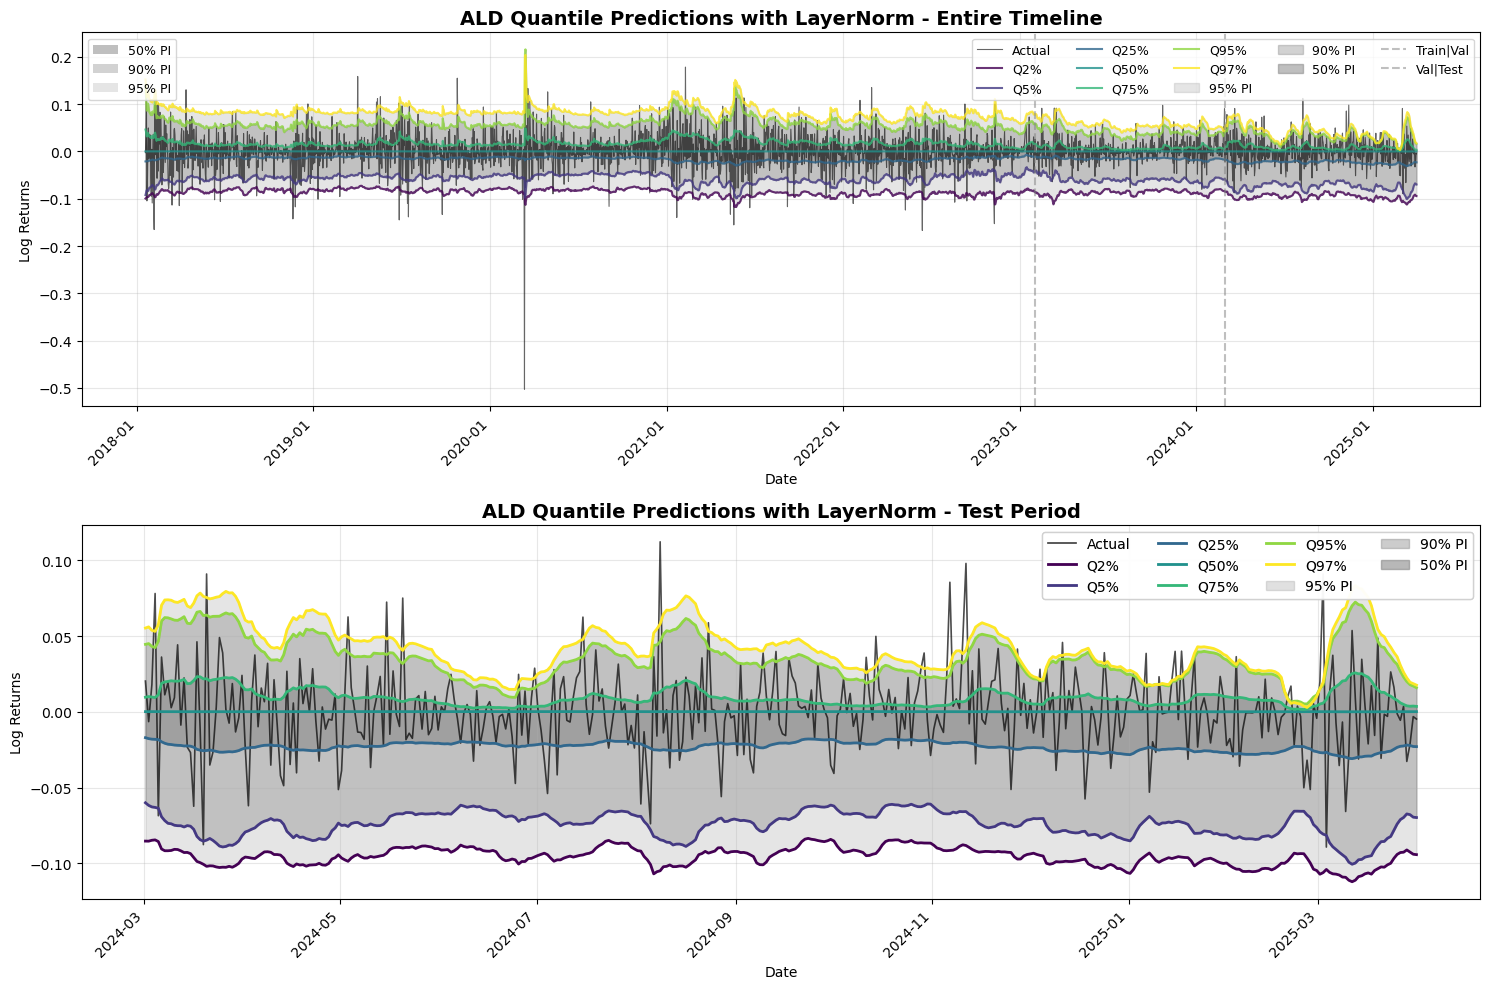


Plots saved to 'ald_timeline_results_layernorm.png'


In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 1. Set Seeds for Reproducibility
# -------------------------
def set_all_seeds(seed=2015):
    """Set all random seeds for reproducibility"""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

# -------------------------
# 2. Model Definition with LayerNorm
# -------------------------
class AsymmetricLaplaceQuantile(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        use_layer_norm = config.get("use_layer_norm", True)
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, lstm_hidden, 
                           num_layers=lstm_layers,
                           batch_first=True,
                           dropout=dropout if lstm_layers > 1 else 0)
        
        # Optional LayerNorm after LSTM
        self.use_layer_norm = use_layer_norm
        if use_layer_norm:
            self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)
        
        # Build hidden layers
        layers = []
        prev_dim = lstm_hidden
        
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Optional LayerNorm for hidden layers
            if use_layer_norm and i < n_hidden_layers - 1:  # Don't add to last hidden layer
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)
        
    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM if enabled
        if self.use_layer_norm:
            last_hidden = self.lstm_layer_norm(last_hidden)
        
        return self.fc(last_hidden)

# -------------------------
# 3. Loss Function for ALD
# -------------------------
def quantile_loss_with_sigma(y_true, y_pred, config):
    """Asymmetric Laplace loss for quantile regression with sigma - complete NLL"""
    tau = config['tau']
    sigma = config.get('sigma', 1.0)
    
    residuals = y_true - y_pred
    loss = torch.where(
        residuals >= 0,
        tau * residuals,
        (tau - 1) * residuals
    )
    
    # Complete ALD NLL with constant term
    return -torch.log(torch.tensor(tau * (1 - tau), device=y_true.device)) + \
           torch.log(torch.tensor(sigma, device=y_true.device)) + \
           loss.mean() / sigma

def get_best_hyperparameters_from_tuning():
    """
    Returns the best hyperparameters from ALD tuning results with LayerNorm & LR Scheduling
    Based on the tuning results table provided
    """
    best_hyperparams = {
        0.025: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,  # LayerNorm is always enabled in the results
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.05: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.25: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.5: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.75: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.95: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.975: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        }
    }
    
    # Add fixed parameters that are common to all
    for alpha in best_hyperparams:
        best_hyperparams[alpha].update({
            'alpha': alpha  # Add alpha value for each config (quantile level)
        })
    
    return best_hyperparams

# -------------------------
# 5. Train Single Model with LR Scheduler
# -------------------------
def train_single_ald_model(X_train, y_train, X_val, y_val, config):
    """Train a single ALD model with given configuration and LR scheduling"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AsymmetricLaplaceQuantile(config).to(device)
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_val = torch.FloatTensor(X_val).to(device)
    y_val = torch.FloatTensor(y_val).unsqueeze(1).to(device)
    
    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), 
                              lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    else:  # adamw
        optimizer = optim.AdamW(model.parameters(), 
                               lr=config['lr'], 
                               weight_decay=config.get('weight_decay', 0))
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=config.get('scheduler_patience', 20),
        factor=config.get('scheduler_factor', 0.5),
        min_lr=1e-6
    )
    
    # Data loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=config['batch_size'], 
                                        shuffle=True)
    
    # Training
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(config['num_epochs']):
        # Train
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = quantile_loss_with_sigma(batch_y, pred, config)
            loss.backward()
            
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = quantile_loss_with_sigma(y_val, val_pred, config).item()
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                print(f"    Early stopping at epoch {epoch+1}")
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

# -------------------------
# 6. Prepare Data
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets"""
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    
    X_train = X_all[:train_end]
    y_train = y_all[:train_end]
    X_val = X_all[train_end:val_end]
    y_val = y_all[train_end:val_end]
    X_test = X_all[val_end:]
    y_test = y_all[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 7. Simple Plot Functions (updated to your style)
# -------------------------
def plot_simple_timelines(all_predictions, y_all, y_test, df_copy, quantiles):
    """
    Two plots (entire timeline & test period) with:
      - seq_length-aware dates (seq_length=3)
      - viridis line colors for quantiles
      - grey shaded PIs (50/90/95)
      - same legends, alphas, and time formatting you use
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.patches import Patch

    # --- sequence length & date alignment ---
    seq_length = 3
    first_sequence_original_row = seq_length

    # date source (prefer explicit Date column)
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        date_series = pd.to_datetime(df_copy["Date"])
    else:
        date_series = pd.to_datetime(df_copy.index)

    n_all  = int(len(y_all))
    n_test = int(len(y_test))
    test_start_idx = n_all - n_test

    def safe_get(idx):
        return date_series.iloc[idx] if idx < len(date_series) else date_series.iloc[-1]

    # aligned dates (original-row aligned with seq_length offset)
    all_dates  = pd.to_datetime([safe_get(first_sequence_original_row + i) for i in range(n_all)])
    test_dates = pd.to_datetime([safe_get(first_sequence_original_row + test_start_idx + i) for i in range(n_test)])

    # colors & intervals (your style)
    line_colors   = plt.cm.viridis(np.linspace(0, 1, len(quantiles)))
    interval_color = 'gray'
    HAVE_025_975 = (0.025 in quantiles) and (0.975 in quantiles)
    HAVE_005_095 = (0.05  in quantiles) and (0.95  in quantiles)
    HAVE_025_075 = (0.25 in quantiles) and (0.75  in quantiles)

    # figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # ---- Plot 1: Entire Timeline (your exact style) ----
    ax1.plot(all_dates, np.asarray(y_all).flatten(), color='k', alpha=0.6, linewidth=0.8, label='Actual')

    # quantile lines
    for i, tau in enumerate(quantiles):
        ax1.plot(
            all_dates,
            np.asarray(all_predictions[tau]).flatten(),
            color=line_colors[i],
            linewidth=1.5,
            alpha=0.8,
            label=f'Q{int(tau*100)}%'
        )

    # shaded PIs (entire timeline)
    if HAVE_025_975:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.025]).flatten(),
                         np.asarray(all_predictions[0.975]).flatten(),
                         color=interval_color, alpha=0.2, label='95% PI')
    if HAVE_005_095:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.05]).flatten(),
                         np.asarray(all_predictions[0.95]).flatten(),
                         color=interval_color, alpha=0.35, label='90% PI')
    if HAVE_025_075:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.25]).flatten(),
                         np.asarray(all_predictions[0.75]).flatten(),
                         color=interval_color, alpha=0.5, label='50% PI')

    # split markers (Train|Val and Val|Test)
    ax1.axvline(x=all_dates[int(len(y_all)*0.7)], color='gray', linestyle='--', alpha=0.5, label='Train|Val')
    ax1.axvline(x=test_dates[0],                 color='gray', linestyle='--', alpha=0.5, label='Val|Test')

    ax1.set_title('ALD Quantile Predictions with LayerNorm - Entire Timeline', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date'); ax1.set_ylabel('Log Returns')
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # build legend to include PI patches only once (same look)
    pi_handles = []
    if HAVE_025_075:
        pi_handles.append(Patch(facecolor=interval_color, alpha=0.5,  label='50% PI'))
    if HAVE_005_095:
        pi_handles.append(Patch(facecolor=interval_color, alpha=0.35, label='90% PI'))
    if HAVE_025_975:
        pi_handles.append(Patch(facecolor=interval_color, alpha=0.2,  label='95% PI'))

    leg1 = ax1.legend(loc='upper right', ncol=5, fontsize=9)
    if pi_handles:
        ax1.add_artist(leg1)
        ax1.legend(handles=pi_handles, loc='upper left', fontsize=9, frameon=True)

    # ---- Plot 2: Test Period Only (your exact style) ----
    ax2.plot(test_dates, np.asarray(y_test).flatten(), 'k-', alpha=0.7, linewidth=1.2, label='Actual')

    for i, tau in enumerate(quantiles):
        y_pred_test = np.asarray(all_predictions[tau]).flatten()[test_start_idx:]
        ax2.plot(test_dates, y_pred_test, color=line_colors[i], linewidth=2, label=f'Q{int(tau*100)}%')

    # shaded PIs (test only)
    if HAVE_025_975:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.025]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.975]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.2, label='95% PI')
    if HAVE_005_095:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.05]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.95]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.35, label='90% PI')
    if HAVE_025_075:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.25]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.75]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.5, label='50% PI')

    ax2.set_title('ALD Quantile Predictions with LayerNorm - Test Period', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date'); ax2.set_ylabel('Log Returns')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    # legend for test plot
    leg2 = ax2.legend(loc='upper right', ncol=4)
    if pi_handles:
        ax2.add_artist(leg2)

    plt.tight_layout()
    plt.savefig('ald_timeline_results_layernorm.png', dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------
# 8. Main Function
# -------------------------
def run_single_ald_models(X_all, y_all, df_copy, quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]):
    """Train one model per quantile level and visualize results"""
    
    # Set seed
    set_all_seeds(2025)
    
    # Prepare data
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    
    print("="*60)
    print("ALD QUANTILE REGRESSION WITH LAYERNORM - SINGLE RUN")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("="*60)
    
    # Get best hyperparameters
    best_hyperparams = get_best_hyperparameters_from_tuning()
    
    # Store all predictions for entire dataset
    all_predictions = {}
    
    # Train model for each quantile
    for tau in quantiles:
        print(f"\nTraining quantile {tau*100:.1f}%...")
        print(f"  Architecture: LSTM {best_hyperparams[tau]['lstm_hidden_dim']}×{best_hyperparams[tau]['lstm_layers']}")
        print(f"  Hidden layers: {best_hyperparams[tau]['n_hidden1']}-{best_hyperparams[tau]['n_hidden2']}")
        print(f"  LayerNorm: {'Yes' if best_hyperparams[tau]['use_layer_norm'] else 'No'}")
        
        # Get config
        config = best_hyperparams[tau].copy()
        config['tau'] = tau
        config['input_dim'] = X_train.shape[2]
        
        # Train model
        model = train_single_ald_model(X_train, y_train, X_val, y_val, config)
        
        # Get predictions for entire dataset
        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()
        
        all_predictions[tau] = y_pred_all
        
        # Calculate test coverage
        y_pred_test = y_pred_all[-len(y_test):]
        if tau <= 0.5:
            coverage = np.mean(y_test <= y_pred_test)
            expected = tau
        else:
            coverage = np.mean(y_test > y_pred_test)
            expected = 1 - tau
        
        print(f"  Test Coverage: {coverage:.3f} (Expected: {expected:.3f})")
    
    # Create simple timeline plots
    plot_simple_timelines(all_predictions, y_all, y_test, df_copy, quantiles)
    
    print("\nPlots saved to 'ald_timeline_results_layernorm.png'")
    
    return all_predictions

# -------------------------
# 9. Usage
# -------------------------
if __name__ == "__main__":
    # Make sure your data is prepared with seq_length=3 (the architecture was tuned for this)
    # X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)
    
    # Run single model evaluation
    all_predictions = run_single_ald_models(X_all, y_all, df_copy)

ALD QUANTILE REGRESSION WITH LAYERNORM - SINGLE RUN
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

Training quantile 2.5%...
  Architecture: LSTM 102×1
  Hidden layers: 16-41
  LayerNorm: Yes
  Test Coverage: 0.000 (Expected: 0.025)

Training quantile 5.0%...
  Architecture: LSTM 102×1
  Hidden layers: 16-41
  LayerNorm: Yes
  Test Coverage: 0.008 (Expected: 0.050)

Training quantile 25.0%...
  Architecture: LSTM 87×1
  Hidden layers: 48-66
  LayerNorm: Yes
  Test Coverage: 0.162 (Expected: 0.250)

Training quantile 50.0%...
  Architecture: LSTM 87×1
  Hidden layers: 48-66
  LayerNorm: Yes
  Test Coverage: 0.508 (Expected: 0.500)

Training quantile 75.0%...
  Architecture: LSTM 87×1
  Hidden layers: 48-66
  LayerNorm: Yes
  Test Coverage: 0.343 (Expected: 0.250)

Training quantile 95.0%...
  Architecture: LSTM 102×1
  Hidden layers: 16-41
  LayerNorm: Yes
  Test Coverage: 0.101 (Expected: 0.050)

Training quantile 97.5%...
  Architecture: LSTM 102×1
  Hidden la

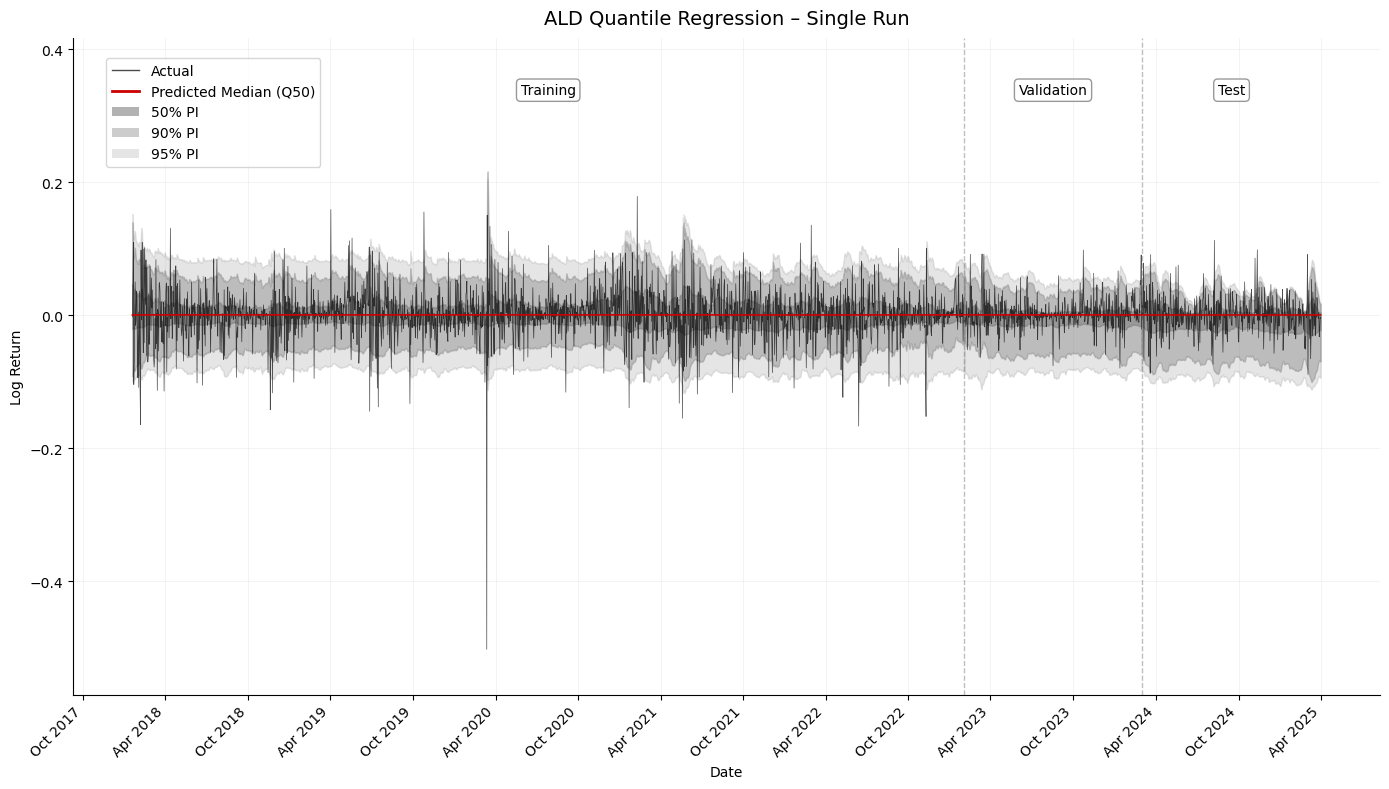

Full timeline plot saved as 'thesis_ald_timelinebefore.png'


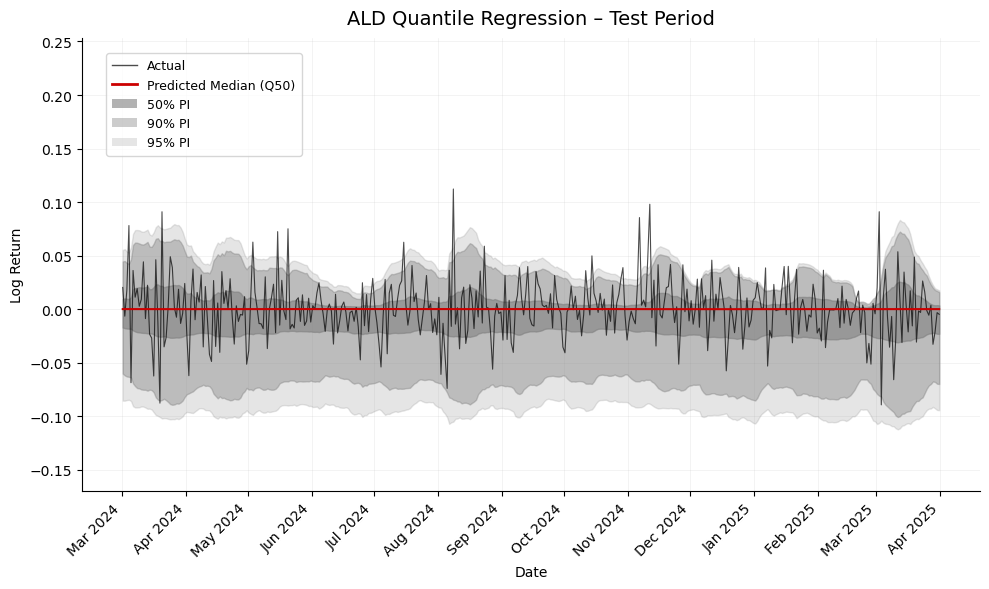

Test period plot saved as 'thesis_ald_testlinebefore.png'

Plots saved to 'thesis_ald_timelinebefore.png' and 'thesis_ald_testlinebefore.png'


In [114]:
# Replace the run_single_ald_models function in your code with this fixed version:
# Replace the plot_simple_timelines function in your ALD code with this:

def plot_simple_timelines(all_predictions, y_all, y_test, df_copy, quantiles):
    """
    Two plots (entire timeline & test period) with thesis-style formatting
    - seq_length-aware dates (seq_length=3)
    - grey shaded PIs (50/90/95)
    - central line, legend formatting, and styling from thesis format
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    # --- Dates aligned to end of each seq ---
    seq_length = 3
    first_seq_row = seq_length

    # Get date source
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        base_dates = pd.to_datetime(df_copy["Date"])
    else:
        base_dates = pd.to_datetime(df_copy.index)

    y_all_np = y_all.detach().cpu().numpy().flatten() if isinstance(y_all, torch.Tensor) else np.asarray(y_all).flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else np.asarray(y_test).flatten()

    n_all = len(y_all_np)
    n_test = len(y_test_np)

    available_dates = base_dates.iloc[seq_length: seq_length + n_all].values
    assert len(available_dates) == n_all, f"Date mismatch: {len(available_dates)} vs {n_all}"

    # Split sizes (respect actual test length)
    train_size = int(round(0.7 * n_all))
    val_size = n_all - train_size - n_test
    test_size = n_test

    train_dates = pd.to_datetime(available_dates[:train_size])
    val_dates = pd.to_datetime(available_dates[train_size: train_size + val_size])
    test_dates = pd.to_datetime(available_dates[train_size + val_size: train_size + val_size + test_size])

    y_train_np = y_all_np[:train_size]
    y_val_np = y_all_np[train_size: train_size + val_size]

    # Central line: Q50 if possible; else mid(Q25,Q75); else mean
    if 0.5 in all_predictions:
        central_full = np.asarray(all_predictions[0.5]).flatten()
    elif (0.25 in all_predictions) and (0.75 in all_predictions):
        central_full = 0.5 * (np.asarray(all_predictions[0.25]).flatten() +
                              np.asarray(all_predictions[0.75]).flatten())
    else:
        stacks = np.column_stack([np.asarray(all_predictions[q]).flatten() for q in quantiles])
        central_full = stacks.mean(axis=1)

    # Bands
    have_95 = (0.025 in all_predictions) and (0.975 in all_predictions)
    have_90 = (0.05 in all_predictions) and (0.95 in all_predictions)
    have_50 = (0.25 in all_predictions) and (0.75 in all_predictions)
    
    if have_95:
        q0025_full = np.asarray(all_predictions[0.025]).flatten()
        q0975_full = np.asarray(all_predictions[0.975]).flatten()
    if have_90:
        q0050_full = np.asarray(all_predictions[0.05]).flatten()
        q0950_full = np.asarray(all_predictions[0.95]).flatten()
    if have_50:
        q0250_full = np.asarray(all_predictions[0.25]).flatten()
        q0750_full = np.asarray(all_predictions[0.75]).flatten()

    # Segment predictions
    cent_train = central_full[:train_size]
    cent_val = central_full[train_size: train_size + val_size]
    cent_test = central_full[train_size + val_size: train_size + val_size + test_size]
    
    if have_95:
        q0025_train, q0025_val, q0025_test = q0025_full[:train_size], q0025_full[train_size: train_size + val_size], q0025_full[train_size + val_size: train_size + val_size + test_size]
        q0975_train, q0975_val, q0975_test = q0975_full[:train_size], q0975_full[train_size: train_size + val_size], q0975_full[train_size + val_size: train_size + val_size + test_size]
    if have_90:
        q0050_train, q0050_val, q0050_test = q0050_full[:train_size], q0050_full[train_size: train_size + val_size], q0050_full[train_size + val_size: train_size + val_size + test_size]
        q0950_train, q0950_val, q0950_test = q0950_full[:train_size], q0950_full[train_size: train_size + val_size], q0950_full[train_size + val_size: train_size + val_size + test_size]
    if have_50:
        q0250_train, q0250_val, q0250_test = q0250_full[:train_size], q0250_full[train_size: train_size + val_size], q0250_full[train_size + val_size: train_size + val_size + test_size]
        q0750_train, q0750_val, q0750_test = q0750_full[:train_size], q0750_full[train_size: train_size + val_size], q0750_full[train_size + val_size: train_size + val_size + test_size]

    # Colors
    actual_color = '#000000'
    pred_color = '#CC0000'
    pi_color = '#808080'

    # ===== Plot 1: Full timeline =====
    fig, ax = plt.subplots(figsize=(14, 8))
    y_min, y_max = y_all_np.min(), y_all_np.max()
    y_range = y_max - y_min if y_max > y_min else 1.0
    ax.set_ylim(y_min - 0.10 * y_range, y_max + 0.35 * y_range)

    # Train
    ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
    ax.plot(train_dates, cent_train, color=pred_color, linewidth=1.2, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(train_dates, q0025_train, q0975_train, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(train_dates, q0050_train, q0950_train, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(train_dates, q0250_train, q0750_train, color=pi_color, alpha=0.6)

    # Val
    if val_size > 0:
        ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
        ax.plot(val_dates, cent_val, color=pred_color, linewidth=1.2)
        if have_95: ax.fill_between(val_dates, q0025_val, q0975_val, color=pi_color, alpha=0.2)
        if have_90: ax.fill_between(val_dates, q0050_val, q0950_val, color=pi_color, alpha=0.4)
        if have_50: ax.fill_between(val_dates, q0250_val, q0750_val, color=pi_color, alpha=0.6)

    # Test
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.2)
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6)

    # Split markers + labels
    ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    if val_size > 0:
        ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)

    y_label_pos = y_max + 0.25 * y_range
    ax.text(train_dates[len(train_dates)//2], y_label_pos, 'Training',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax.text(val_dates[len(val_dates)//2], y_label_pos, 'Validation',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    ax.text(test_dates[len(test_dates)//2], y_label_pos, 'Test',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))

    # Dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    total_days = (test_dates[-1] - train_dates[0]).days
    if total_days > 365*2:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    elif total_days > 365:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45, ha='right')

    # Legend
    legend_elements = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, ncol=1, fontsize=10,
              bbox_to_anchor=(0.02, 0.98))

    ax.set_title('ALD Quantile Regression – Single Run', fontsize=14, pad=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('thesis_ald_timelinebefore.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Full timeline plot saved as 'thesis_ald_timelinebefore.png'")

    # ===== Plot 2: Test period =====
    fig, ax = plt.subplots(figsize=(10, 6))
    y_min_t, y_max_t = y_test_np.min(), y_test_np.max()
    y_rng_t = y_max_t - y_min_t if y_max_t > y_min_t else 1.0
    ax.set_ylim(y_min_t - 0.4*y_rng_t, y_max_t + 0.7*y_rng_t)

    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.5, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2, label='95% PI')
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4, label='90% PI')
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6, label='50% PI')

    test_days = (test_dates[-1] - test_dates[0]).days
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if test_days > 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_days > 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_days > 30:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_days > 14:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45, ha='right')

    legend_elements_test = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements_test, loc='upper left',
              frameon=True, ncol=1, fontsize=9,
              bbox_to_anchor=(0.02, 0.98),
              borderpad=0.5, columnspacing=1.0, handlelength=2.0,
              handletextpad=0.8, labelspacing=0.5)

    ax.set_title('ALD Quantile Regression – Test Period', fontsize=14, pad=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('thesis_ald_testlinebefore.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Test period plot saved as 'thesis_ald_testlinebefore.png'")
def run_single_ald_models(X_all, y_all, df_copy, quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]):
    """Train one model per quantile level and visualize results"""
    
    # Set seed
    set_all_seeds(2025)
    
    # Prepare data
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)
    
    print("="*60)
    print("ALD QUANTILE REGRESSION WITH LAYERNORM - SINGLE RUN")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("="*60)
    
    # Get best hyperparameters
    best_hyperparams = get_best_hyperparameters_from_tuning()
    
    # Store all predictions for entire dataset
    all_predictions = {}
    
    # Train model for each quantile
    for tau in quantiles:
        print(f"\nTraining quantile {tau*100:.1f}%...")
        print(f"  Architecture: LSTM {best_hyperparams[tau]['lstm_hidden_dim']}×{best_hyperparams[tau]['lstm_layers']}")
        print(f"  Hidden layers: {best_hyperparams[tau]['n_hidden1']}-{best_hyperparams[tau]['n_hidden2']}")
        print(f"  LayerNorm: {'Yes' if best_hyperparams[tau]['use_layer_norm'] else 'No'}")
        
        # Get config
        config = best_hyperparams[tau].copy()
        config['tau'] = tau
        config['input_dim'] = X_train.shape[2]
        
        # Train model
        model = train_single_ald_model(X_train, y_train, X_val, y_val, config)
        
        # Get predictions for entire dataset
        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()
        
        all_predictions[tau] = y_pred_all
        
        # Calculate test coverage
        y_pred_test = y_pred_all[-len(y_test):]
        if tau <= 0.5:
            coverage = np.mean(y_test <= y_pred_test)
            expected = tau
        else:
            coverage = np.mean(y_test > y_pred_test)
            expected = 1 - tau
        
        print(f"  Test Coverage: {coverage:.3f} (Expected: {expected:.3f})")
    
    # Create simple timeline plots - FIXED: removed out_png parameter
    plot_simple_timelines(all_predictions, y_all, y_test, df_copy, quantiles)
    
    print("\nPlots saved to 'thesis_ald_timelinebefore.png' and 'thesis_ald_testlinebefore.png'")
    
    return all_predictions
# Simply execute this line after you have loaded your data:
all_predictions = run_single_ald_models(X_all, y_all, df_copy)

## 5. Model selection

ALD QUANTILE REGRESSION - 10 REPEATS MODEL SELECTION
WITH LAYERNORM & LR SCHEDULING
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

===== Quantile 2.5% =====

Training 15 models for quantile 2.5% with best hyperparameters
  Repeat 1: score=0.6022 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 2: score=0.6152 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 3: score=0.6065 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 4: score=0.6000 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 5: score=0.6130 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 6: score=0.6174 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 7: score=0.6022 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 8: score=0.6152 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 9: score=0.6000 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 10: score=0.6065 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 11: score=0.6043 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 12: score=0.6130 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 13: score=0.6000 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 14: score=0.6

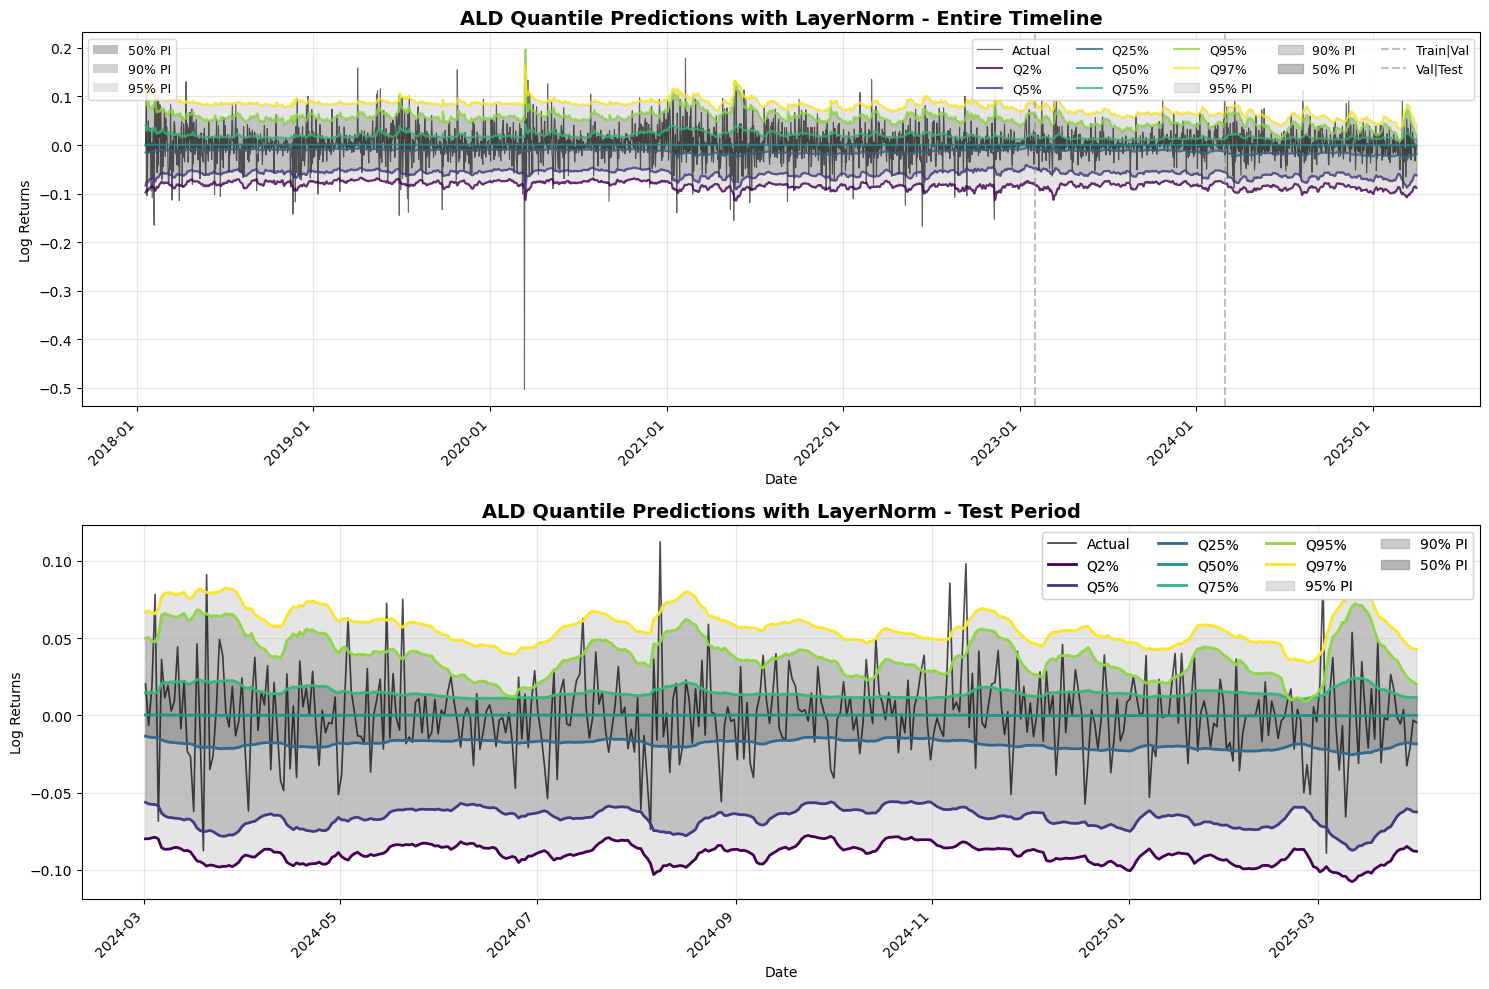


Plots saved to 'ald_timeline_results_selected_layernorm.png'


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 1. Set Seeds for Reproducibility
# -------------------------
def set_all_seeds(seed=2015):
    """Set all random seeds for reproducibility"""
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

# -------------------------
# 2. Model Definition with LayerNorm
# -------------------------
class AsymmetricLaplaceQuantile(nn.Module):
    def __init__(self, config):
        super().__init__()
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        use_layer_norm = config.get("use_layer_norm", True)

        self.lstm = nn.LSTM(
            input_dim, lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0
        )

        # Optional LayerNorm after LSTM
        self.use_layer_norm = use_layer_norm
        if use_layer_norm:
            self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)

        layers = []
        prev_dim = lstm_hidden
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Optional LayerNorm for hidden layers
            if use_layer_norm and i < n_hidden_layers - 1:  # Don't add to last hidden layer
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)

    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM if enabled
        if self.use_layer_norm:
            last_hidden = self.lstm_layer_norm(last_hidden)
        
        return self.fc(last_hidden)

# -------------------------
# 3. Loss Function for ALD
# -------------------------
def quantile_loss_with_sigma(y_true, y_pred, config):
    """Asymmetric Laplace loss for quantile regression with sigma - complete NLL"""
    tau = config['tau']
    sigma = config.get('sigma', 1.0)
    
    residuals = y_true - y_pred
    loss = torch.where(
        residuals >= 0,
        tau * residuals,
        (tau - 1) * residuals
    )
    
    # Complete ALD NLL with constant term
    return -torch.log(torch.tensor(tau * (1 - tau), device=y_true.device)) + \
           torch.log(torch.tensor(sigma, device=y_true.device)) + \
           loss.mean() / sigma

# -------------------------
# 4. Get Best Hyperparameters with LayerNorm
# -------------------------

def get_best_hyperparameters_from_tuning():
    """
    Returns the best hyperparameters from ALD tuning results with LayerNorm & LR Scheduling
    Based on the tuning results table provided
    """
    best_hyperparams = {
        0.025: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,  # LayerNorm is always enabled in the results
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.05: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.25: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.5: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.75: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.95: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.975: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        }
    }
    
    # Add fixed parameters that are common to all
    for alpha in best_hyperparams:
        best_hyperparams[alpha].update({
            'alpha': alpha  # Add alpha value for each config (quantile level)
        })
    
    return best_hyperparams

# -------------------------
# 5. Train Single Model with LR Scheduler
# -------------------------
def train_single_ald_model(X_train, y_train, X_val, y_val, config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AsymmetricLaplaceQuantile(config).to(device)

    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    # Tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_val   = torch.FloatTensor(X_val).to(device)
    y_val   = torch.FloatTensor(y_val).unsqueeze(1).to(device)

    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=config.get('scheduler_patience', 20),
        factor=config.get('scheduler_factor', 0.5),
        min_lr=1e-6
    )

    # Loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)

    # Train
    best_val_loss, patience_counter, best_model_state = float('inf'), 0, None
    for epoch in range(config['num_epochs']):
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = quantile_loss_with_sigma(batch_y, pred, config)
            loss.backward()
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = quantile_loss_with_sigma(y_val, val_pred, config).item()

        # Update learning rate
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model

# -------------------------
# 6. Prepare Data
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    X_train = X_all[:train_end];   y_train = y_all[:train_end]
    X_val   = X_all[train_end:val_end]; y_val = y_all[train_end:val_end]
    X_test  = X_all[val_end:];     y_test = y_all[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 7. Visualisations (same two plots)
# -------------------------
def plot_simple_timelines(all_predictions, y_all, y_test, df_copy, quantiles, out_png):
    """
    Two plots (entire timeline & test period) using your preferred style:
      - seq_length-aware dates (seq_length=3)
      - viridis lines for quantiles
      - grey shaded PIs (50/90/95)
      - train/val/test split markers and monthly ticks
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.patches import Patch

    # --- sequence length & date alignment ---
    seq_length = 3
    first_seq_row = seq_length

    # choose date source
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        date_series = pd.to_datetime(df_copy["Date"])
    else:
        date_series = pd.to_datetime(df_copy.index)

    n_all = int(len(y_all))
    n_test = int(len(y_test))
    test_start_idx = n_all - n_test

    def safe_get(idx):
        return date_series.iloc[idx] if idx < len(date_series) else date_series.iloc[-1]

    all_dates  = pd.to_datetime([safe_get(first_seq_row + i) for i in range(n_all)])
    test_dates = pd.to_datetime([safe_get(first_seq_row + test_start_idx + i) for i in range(n_test)])

    # colors & intervals
    line_colors = plt.cm.viridis(np.linspace(0, 1, len(quantiles)))
    interval_color = 'gray'
    HAVE_025_975 = (0.025 in quantiles) and (0.975 in quantiles)
    HAVE_005_095 = (0.05  in quantiles) and (0.95  in quantiles)
    HAVE_025_075 = (0.25 in quantiles) and (0.75  in quantiles)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # ---- Entire timeline ----
    ax1.plot(all_dates, np.asarray(y_all).flatten(), color='k', alpha=0.6, linewidth=0.8, label='Actual')

    for i, tau in enumerate(quantiles):
        ax1.plot(all_dates, np.asarray(all_predictions[tau]).flatten(),
                 color=line_colors[i], linewidth=1.5, alpha=0.8, label=f'Q{int(tau*100)}%')

    # shaded PIs over full timeline
    if HAVE_025_975:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.025]).flatten(),
                         np.asarray(all_predictions[0.975]).flatten(),
                         color=interval_color, alpha=0.2, label='95% PI')
    if HAVE_005_095:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.05]).flatten(),
                         np.asarray(all_predictions[0.95]).flatten(),
                         color=interval_color, alpha=0.35, label='90% PI')
    if HAVE_025_075:
        ax1.fill_between(all_dates,
                         np.asarray(all_predictions[0.25]).flatten(),
                         np.asarray(all_predictions[0.75]).flatten(),
                         color=interval_color, alpha=0.5, label='50% PI')

    # split markers
    ax1.axvline(x=all_dates[int(len(y_all)*0.7)], color='gray', linestyle='--', alpha=0.5, label='Train|Val')
    ax1.axvline(x=test_dates[0],                 color='gray', linestyle='--', alpha=0.5, label='Val|Test')

    ax1.set_title('ALD Quantile Predictions with LayerNorm - Entire Timeline', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date'); ax1.set_ylabel('Log Returns')
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # legend: lines + PI patches
    pi_handles = []
    if HAVE_025_075: pi_handles.append(Patch(facecolor=interval_color, alpha=0.5,  label='50% PI'))
    if HAVE_005_095: pi_handles.append(Patch(facecolor=interval_color, alpha=0.35, label='90% PI'))
    if HAVE_025_975: pi_handles.append(Patch(facecolor=interval_color, alpha=0.2,  label='95% PI'))
    leg1 = ax1.legend(loc='upper right', ncol=5, fontsize=9)
    if pi_handles:
        ax1.add_artist(leg1)
        ax1.legend(handles=pi_handles, loc='upper left', fontsize=9, frameon=True)

    # ---- Test period ----
    ax2.plot(test_dates, np.asarray(y_test).flatten(), 'k-', alpha=0.7, linewidth=1.2, label='Actual')

    for i, tau in enumerate(quantiles):
        y_pred_test = np.asarray(all_predictions[tau]).flatten()[test_start_idx:]
        ax2.plot(test_dates, y_pred_test, color=line_colors[i], linewidth=2, label=f'Q{int(tau*100)}%')

    # shaded PIs (test)
    if HAVE_025_975:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.025]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.975]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.2, label='95% PI')
    if HAVE_005_095:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.05]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.95]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.35, label='90% PI')
    if HAVE_025_075:
        ax2.fill_between(test_dates,
                         np.asarray(all_predictions[0.25]).flatten()[test_start_idx:],
                         np.asarray(all_predictions[0.75]).flatten()[test_start_idx:],
                         color=interval_color, alpha=0.5, label='50% PI')

    ax2.set_title('ALD Quantile Predictions with LayerNorm - Test Period', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date'); ax2.set_ylabel('Log Returns')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    leg2 = ax2.legend(loc='upper right', ncol=4)
    if pi_handles:
        ax2.add_artist(leg2)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------
# 8. Composite score (same criteria you used)
# -------------------------
def composite_score_coverage_loss(y_true_train, y_pred_train,
                                  y_true_val, y_pred_val,
                                  y_true_test, y_pred_test,
                                  tau, train_loss, val_loss, test_loss):
    """
    Same weighting:
      20% train_CRP + 20% val_CRP + 20% test_CRP +
      15% train_loss + 15% val_loss + 10% test_loss
    where CRP = |1 - (actual_coverage/target_coverage)|
    """
    def coverage_parts(y_true, y_pred, tau):
        y_true = y_true.flatten(); y_pred = y_pred.flatten()
        if tau <= 0.5:
            actual = np.mean(y_true <= y_pred)
            target = tau
        else:
            actual = np.mean(y_true > y_pred)
            target = 1 - tau
        ratio = actual / target if target > 0 else 1.0
        return actual, target, ratio, abs(1.0 - ratio)

    tr = coverage_parts(y_true_train, y_pred_train, tau)
    va = coverage_parts(y_true_val,   y_pred_val,   tau)
    te = coverage_parts(y_true_test,  y_pred_test,  tau)

    # normalize losses w.r.t. data scale (like your earlier approach)
    data_scale = max(np.std(y_true_train.flatten()), 1e-3)
    train_loss_norm = min(train_loss / data_scale / 10.0, 1.0)
    val_loss_norm   = min(val_loss   / data_scale / 10.0, 1.0)
    test_loss_norm  = min(test_loss  / data_scale / 10.0, 1.0)

    train_crp_std = min(tr[3], 2.0) / 2.0
    val_crp_std   = min(va[3], 2.0) / 2.0
    test_crp_std  = min(te[3], 2.0) / 2.0

    score = (0.2 * train_crp_std +
             0.2 * val_crp_std   +
             0.2 * test_crp_std  +
             0.15 * train_loss_norm +
             0.15 * val_loss_norm   +
             0.10 * test_loss_norm)

    metrics = {
        'train': {'actual_coverage': tr[0], 'target_coverage': tr[1], 'coverage_ratio': tr[2], 'coverage_ratio_penalty': tr[3]},
        'val':   {'actual_coverage': va[0], 'target_coverage': va[1], 'coverage_ratio': va[2], 'coverage_ratio_penalty': va[3]},
        'test':  {'actual_coverage': te[0], 'target_coverage': te[1], 'coverage_ratio': te[2], 'coverage_ratio_penalty': te[3]},
        'losses': {'train': train_loss, 'val': val_loss, 'test': test_loss}
    }
    return score, metrics

# -------------------------
# 9. 5-repeat selection per quantile (uses same criteria)
# -------------------------
def train_ald_with_repeats(X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats=10):
    best_hps = get_best_hyperparameters_from_tuning()
    if tau not in best_hps:
        raise ValueError(f"No hyperparameters found for quantile {tau}")

    base_config = best_hps[tau].copy()
    base_config['tau'] = tau
    base_config['input_dim'] = X_train.shape[2]

    print(f"\nTraining {n_repeats} models for quantile {tau*100:.1f}% with best hyperparameters")

    results = []
    for r in range(n_repeats):
        seed = 2025 + (r + 1) * 100
        set_all_seeds(seed)

        config = base_config.copy()
        model = train_single_ald_model(X_train, y_train, X_val, y_val, config)

        # evaluate on all sets
        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            Xt = torch.FloatTensor(X_train).to(device)
            Xv = torch.FloatTensor(X_val).to(device)
            Xs = torch.FloatTensor(X_test).to(device)

            yt = torch.FloatTensor(y_train).unsqueeze(1).to(device)
            yv = torch.FloatTensor(y_val).unsqueeze(1).to(device)
            ys = torch.FloatTensor(y_test).unsqueeze(1).to(device)

            pt = model(Xt); pv = model(Xv); ps = model(Xs)

            train_loss = quantile_loss_with_sigma(yt, pt, config).item()
            val_loss   = quantile_loss_with_sigma(yv, pv, config).item()
            test_loss  = quantile_loss_with_sigma(ys, ps, config).item()

        # to numpy for coverage calc
        pt_np = pt.detach().cpu().numpy()
        pv_np = pv.detach().cpu().numpy()
        ps_np = ps.detach().cpu().numpy()

        score, metrics = composite_score_coverage_loss(
            y_train, pt_np, y_val, pv_np, y_test, ps_np, tau,
            train_loss, val_loss, test_loss
        )

        results.append({
            'seed': seed,
            'score': score,
            'metrics': metrics,
            'state_dict': {k:v.cpu() for k,v in model.state_dict().items()}
        })

        print(f"  Repeat {r+1}: score={score:.4f} | "
              f"Val_CRP={metrics['val']['coverage_ratio_penalty']:.3f} "
              f"Test_CRP={metrics['test']['coverage_ratio_penalty']:.3f}")

        # cleanup
        del model, Xt, Xv, Xs, yt, yv, ys, pt, pv, ps
        torch.cuda.empty_cache()

    # pick best (tie-break on val CRP)
    results.sort(key=lambda d: d['score'])
    best_score = results[0]['score']
    tied = [d for d in results if abs(d['score'] - best_score) < 1e-6]
    if len(tied) > 1:
        tied.sort(key=lambda d: d['metrics']['val']['coverage_ratio_penalty'])
        best = tied[0]
    else:
        best = results[0]

    print(f"Best seed {best['seed']} with score {best['score']:.4f}")
    return best, results

# -------------------------
# 10. Run 5-repeat selection across quantiles + same visualisations
# -------------------------
def run_ald_model_selection_10repeats(X_all, y_all, df_copy,
                                     quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
                                     n_repeats=15):
    set_all_seeds(2025)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)

    print("="*60)
    print("ALD QUANTILE REGRESSION - 10 REPEATS MODEL SELECTION")
    print("WITH LAYERNORM & LR SCHEDULING")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("="*60)

    best_predictions_full = {}     # predictions on full timeline for the selected model per quantile
    selection_summary = {}

    for tau in quantiles:
        print(f"\n===== Quantile {tau*100:.1f}% =====")
        best, all_repeats = train_ald_with_repeats(
            X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats
        )

        # rebuild model and load best state for full predictions
        cfg = get_best_hyperparameters_from_tuning()[tau].copy()
        cfg['tau'] = tau
        cfg['input_dim'] = X_train.shape[2]

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = AsymmetricLaplaceQuantile(cfg).to(device)
        model.load_state_dict(best['state_dict'])
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()

        best_predictions_full[tau] = y_pred_all

        # compute and print test coverage (like your single run printout)
        y_pred_test = y_pred_all[-len(y_test):]
        if tau <= 0.5:
            coverage = np.mean(y_test <= y_pred_test)
            expected = tau
        else:
            coverage = np.mean(y_test > y_pred_test)
            expected = 1 - tau
        print(f"  Selected model test coverage: {coverage:.3f} (Expected: {expected:.3f})")

        selection_summary[tau] = {
            'seed': best['seed'],
            'score': best['score'],
            'metrics': best['metrics']
        }

        # cleanup
        del model, X_all_tensor
        torch.cuda.empty_cache()

    # same visualisations as your single-run, but for the selected best models
    plot_simple_timelines(
        best_predictions_full, y_all, y_test, df_copy, quantiles,
        out_png='ald_timeline_results_selected_layernorm.png'
    )
    print("\nPlots saved to 'ald_timeline_results_selected_layernorm.png'")

    return best_predictions_full, selection_summary

# -------------------------
# 11. Single-run (unchanged, if you still want to call it)
# -------------------------
def run_single_ald_models(X_all, y_all, df_copy, quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]):
    set_all_seeds(2025)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)

    print("="*60)
    print("ALD QUANTILE REGRESSION - SINGLE RUN WITH LAYERNORM & LR SCHEDULING")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("="*60)

    best_hyperparams = get_best_hyperparameters_from_tuning()
    all_predictions = {}

    for tau in quantiles:
        print(f"\nTraining quantile {tau*100:.1f}%...")
        print(f"  Architecture: LSTM {best_hyperparams[tau]['lstm_hidden_dim']}×{best_hyperparams[tau]['lstm_layers']}")
        print(f"  Hidden layers: {best_hyperparams[tau]['n_hidden1']}-{best_hyperparams[tau]['n_hidden2']}")
        print(f"  LayerNorm: Yes | LR Scheduler: Yes")
        
        config = best_hyperparams[tau].copy()
        config['tau'] = tau
        config['input_dim'] = X_train.shape[2]

        model = train_single_ald_model(X_train, y_train, X_val, y_val, config)

        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()

        all_predictions[tau] = y_pred_all

        y_pred_test = y_pred_all[-len(y_test):]
        if tau <= 0.5:
            coverage = np.mean(y_test <= y_pred_test); expected = tau
        else:
            coverage = np.mean(y_test > y_pred_test); expected = 1 - tau
        print(f"  Test Coverage: {coverage:.3f} (Expected: {expected:.3f})")

    plot_simple_timelines(all_predictions, y_all, y_test, df_copy, quantiles,
                          out_png='ald_timeline_results_layernorm.png')
    print("\nPlots saved to 'ald_timeline_results_layernorm.png'")
    return all_predictions

# -------------------------
# 12. Usage
# -------------------------
if __name__ == "__main__":
    # Make sure your data is prepared with seq_length=3 (the architecture was tuned for this)
    # X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)

    # 10-repeat selection (recommended)
    best_predictions, selection_summary = run_ald_model_selection_10repeats(
        X_all, y_all, df_copy,
        quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
        n_repeats=15
    )

    # If you also want the single run:
    # all_predictions_single = run_single_ald_models(X_all, y_all, df_copy)

ALD QUANTILE REGRESSION - 70 REPEATS MODEL SELECTION
WITH LAYERNORM & LR SCHEDULING
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

===== Quantile 2.5% =====

Training 70 models for quantile 2.5% with best hyperparameters
  Repeat 1: score=0.6022 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 2: score=0.6152 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 3: score=0.6065 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 4: score=0.6000 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 5: score=0.6130 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 6: score=0.6174 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 7: score=0.6022 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 8: score=0.6152 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 9: score=0.6000 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 10: score=0.6065 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 11: score=0.6043 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 12: score=0.6130 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 13: score=0.6000 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 14: score=0.6

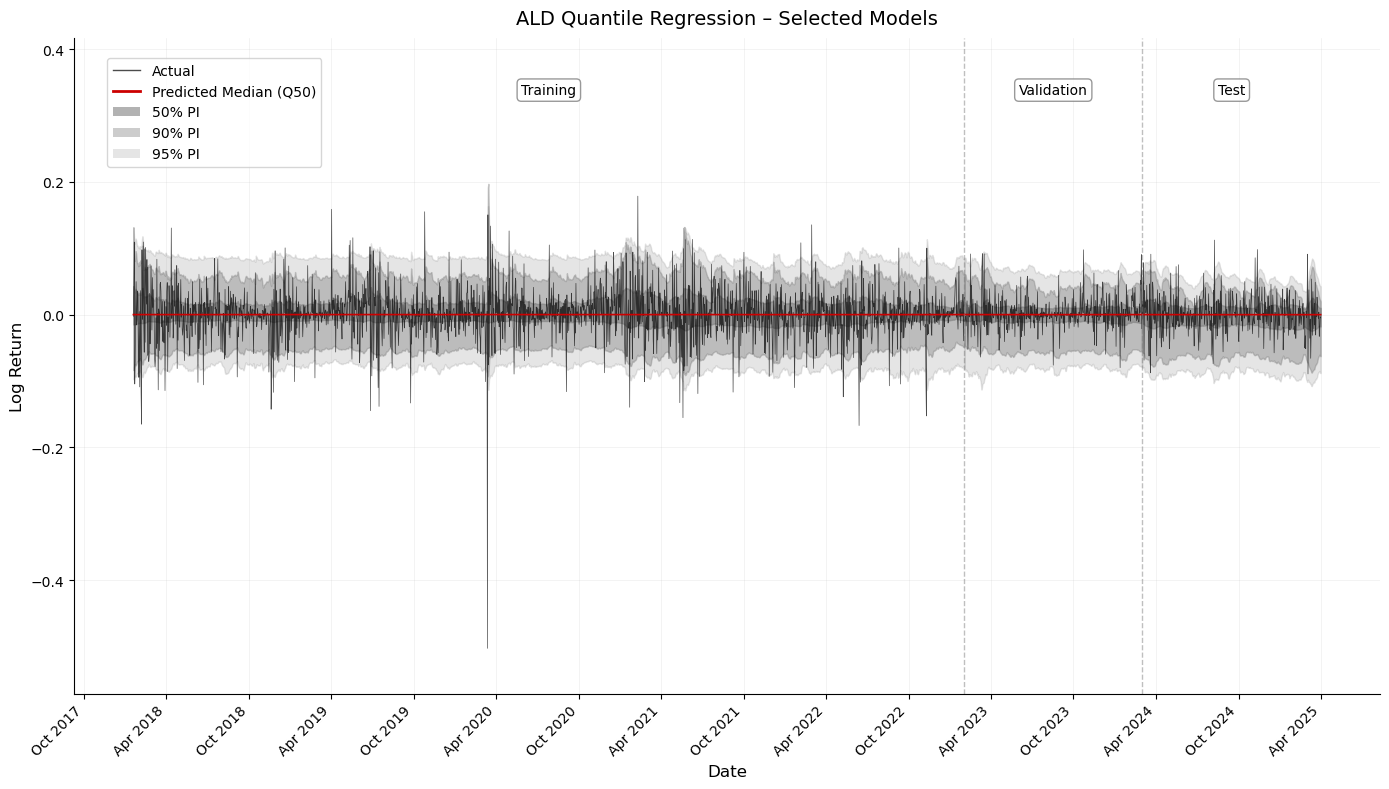

Full timeline plot saved as 'ald_timeline_thesis.png'


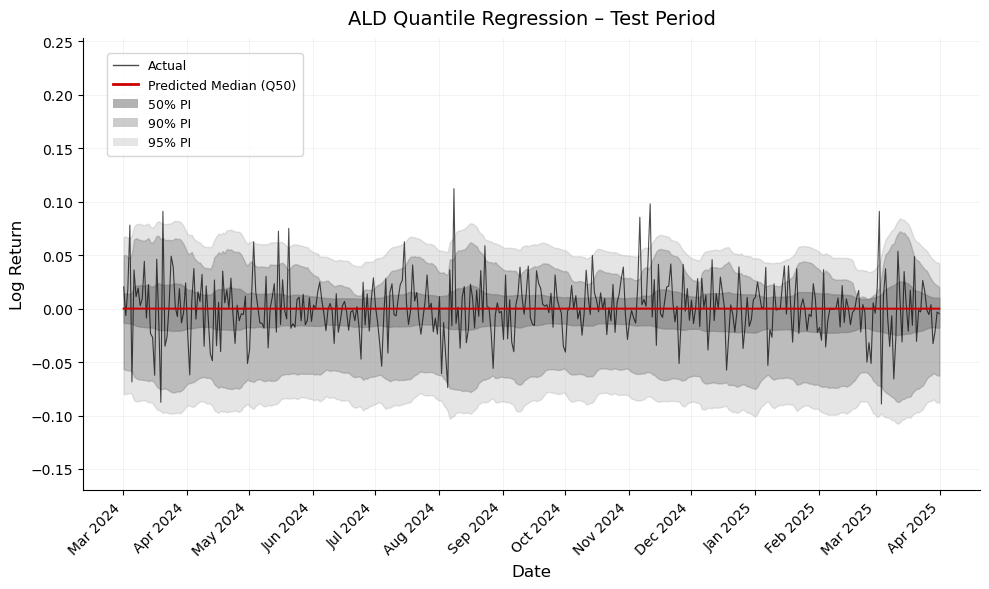

Test period plot saved as 'ald_testline_thesis.png'

Plots saved to 'ald_timeline_thesis.png' and 'ald_testline_thesis.png'


In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 1. Set Seeds for Reproducibility
# -------------------------
def set_all_seeds(seed=2015):
    """Set all random seeds for reproducibility"""
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

# -------------------------
# 2. Model Definition with LayerNorm
# -------------------------
class AsymmetricLaplaceQuantile(nn.Module):
    def __init__(self, config):
        super().__init__()
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        use_layer_norm = config.get("use_layer_norm", True)

        self.lstm = nn.LSTM(
            input_dim, lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0
        )

        # Optional LayerNorm after LSTM
        self.use_layer_norm = use_layer_norm
        if use_layer_norm:
            self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)

        layers = []
        prev_dim = lstm_hidden
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Optional LayerNorm for hidden layers
            if use_layer_norm and i < n_hidden_layers - 1:  # Don't add to last hidden layer
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)

    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM if enabled
        if self.use_layer_norm:
            last_hidden = self.lstm_layer_norm(last_hidden)
        
        return self.fc(last_hidden)

# -------------------------
# 3. Loss Function for ALD
# -------------------------
def quantile_loss_with_sigma(y_true, y_pred, config):
    """Asymmetric Laplace loss for quantile regression with sigma - complete NLL"""
    tau = config['tau']
    sigma = config.get('sigma', 1.0)
    
    residuals = y_true - y_pred
    loss = torch.where(
        residuals >= 0,
        tau * residuals,
        (tau - 1) * residuals
    )
    
    # Complete ALD NLL with constant term
    return -torch.log(torch.tensor(tau * (1 - tau), device=y_true.device)) + \
           torch.log(torch.tensor(sigma, device=y_true.device)) + \
           loss.mean() / sigma

# -------------------------
# 4. Get Best Hyperparameters with LayerNorm
# -------------------------

def get_best_hyperparameters_from_tuning():
    """
    Returns the best hyperparameters from ALD tuning results with LayerNorm & LR Scheduling
    Based on the tuning results table provided
    """
    best_hyperparams = {
        0.025: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,  # LayerNorm is always enabled in the results
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.05: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.25: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.5: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.75: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.95: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.975: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        }
    }
    
    # Add fixed parameters that are common to all
    for alpha in best_hyperparams:
        best_hyperparams[alpha].update({
            'alpha': alpha  # Add alpha value for each config (quantile level)
        })
    
    return best_hyperparams

# -------------------------
# 5. Train Single Model with LR Scheduler
# -------------------------
def train_single_ald_model(X_train, y_train, X_val, y_val, config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AsymmetricLaplaceQuantile(config).to(device)

    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    # Tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_val   = torch.FloatTensor(X_val).to(device)
    y_val   = torch.FloatTensor(y_val).unsqueeze(1).to(device)

    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=config.get('scheduler_patience', 20),
        factor=config.get('scheduler_factor', 0.5),
        min_lr=1e-6
    )

    # Loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)

    # Train
    best_val_loss, patience_counter, best_model_state = float('inf'), 0, None
    for epoch in range(config['num_epochs']):
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = quantile_loss_with_sigma(batch_y, pred, config)
            loss.backward()
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = quantile_loss_with_sigma(y_val, val_pred, config).item()

        # Update learning rate
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model

# -------------------------
# 6. Prepare Data
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    X_train = X_all[:train_end];   y_train = y_all[:train_end]
    X_val   = X_all[train_end:val_end]; y_val = y_all[train_end:val_end]
    X_test  = X_all[val_end:];     y_test = y_all[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 7. Visualisations (thesis-style formatting)
# -------------------------
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_quantiles_formatted(
    all_predictions,               # dict: {tau -> np.array over *full* timeline}
    y_all,                         # full actual y
    y_test,                        # test actual y (length used for split)
    df_copy,                       # has 'Date' or DatetimeIndex
    quantiles,                     # list of taus
    train_ratio=0.70,
    val_ratio=0.15,
    seq_length=3,
    out_timeline_png='ald_timeline_thesis.png',
    out_test_png='ald_testline_thesis.png'
):
    # --- Dates aligned to end of each sequence ---
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        base_dates = pd.to_datetime(df_copy["Date"])
    else:
        base_dates = pd.to_datetime(df_copy.index)

    y_all_np  = y_all.detach().cpu().numpy().flatten() if isinstance(y_all, torch.Tensor) else np.asarray(y_all).flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else np.asarray(y_test).flatten()

    n_all  = len(y_all_np)
    n_test = len(y_test_np)

    available_dates = base_dates.iloc[seq_length: seq_length + n_all].values
    assert len(available_dates) == n_all, f"Date mismatch: {len(available_dates)} vs {n_all}"

    # Split sizes (respect actual test length)
    train_size = int(round(train_ratio * n_all))
    val_size   = n_all - train_size - n_test
    test_size  = n_test

    train_dates = pd.to_datetime(available_dates[:train_size])
    val_dates   = pd.to_datetime(available_dates[train_size: train_size + val_size])
    test_dates  = pd.to_datetime(available_dates[train_size + val_size: train_size + val_size + test_size])

    y_train_np = y_all_np[:train_size]
    y_val_np   = y_all_np[train_size: train_size + val_size]

    # Central line: Q50 if present; else mid of Q25/Q75; else mean of all curves
    if 0.5 in all_predictions:
        central_full = np.asarray(all_predictions[0.5]).flatten()
    elif (0.25 in all_predictions) and (0.75 in all_predictions):
        central_full = 0.5 * (np.asarray(all_predictions[0.25]).flatten() +
                              np.asarray(all_predictions[0.75]).flatten())
    else:
        stacks = np.column_stack([np.asarray(all_predictions[q]).flatten() for q in quantiles])
        central_full = stacks.mean(axis=1)

    # Bands availability
    have_95 = (0.025 in all_predictions) and (0.975 in all_predictions)
    have_90 = (0.05  in all_predictions) and (0.95  in all_predictions)
    have_50 = (0.25  in all_predictions) and (0.75  in all_predictions)

    if have_95:
        q0025_full = np.asarray(all_predictions[0.025]).flatten()
        q0975_full = np.asarray(all_predictions[0.975]).flatten()
    if have_90:
        q0050_full = np.asarray(all_predictions[0.05]).flatten()
        q0950_full = np.asarray(all_predictions[0.95]).flatten()
    if have_50:
        q0250_full = np.asarray(all_predictions[0.25]).flatten()
        q0750_full = np.asarray(all_predictions[0.75]).flatten()

    # Segment predictions
    cent_train = central_full[:train_size]
    cent_val   = central_full[train_size: train_size + val_size]
    cent_test  = central_full[train_size + val_size: train_size + val_size + test_size]

    if have_95:
        q0025_train, q0025_val, q0025_test = q0025_full[:train_size], q0025_full[train_size: train_size + val_size], q0025_full[train_size + val_size: train_size + val_size + test_size]
        q0975_train, q0975_val, q0975_test = q0975_full[:train_size], q0975_full[train_size: train_size + val_size], q0975_full[train_size + val_size: train_size + val_size + test_size]
    if have_90:
        q0050_train, q0050_val, q0050_test = q0050_full[:train_size], q0050_full[train_size: train_size + val_size], q0050_full[train_size + val_size: train_size + val_size + test_size]
        q0950_train, q0950_val, q0950_test = q0950_full[:train_size], q0950_full[train_size: train_size + val_size], q0950_full[train_size + val_size: train_size + val_size + test_size]
    if have_50:
        q0250_train, q0250_val, q0250_test = q0250_full[:train_size], q0250_full[train_size: train_size + val_size], q0250_full[train_size + val_size: train_size + val_size + test_size]
        q0750_train, q0750_val, q0750_test = q0750_full[:train_size], q0750_full[train_size: train_size + val_size], q0750_full[train_size + val_size: train_size + val_size + test_size]

    # Colors to match your t-style
    actual_color = '#000000'
    pred_color   = '#CC0000'
    pi_color     = '#808080'

    # ========= Plot 1: Full timeline =========
    fig, ax = plt.subplots(figsize=(14, 8))

    y_min, y_max = y_all_np.min(), y_all_np.max()
    y_range = y_max - y_min if y_max > y_min else 1.0
    ax.set_ylim(y_min - 0.10 * y_range, y_max + 0.35 * y_range)

    # Train
    ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
    ax.plot(train_dates, cent_train, color=pred_color, linewidth=1.2, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(train_dates, q0025_train, q0975_train, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(train_dates, q0050_train, q0950_train, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(train_dates, q0250_train, q0750_train, color=pi_color, alpha=0.6)

    # Val
    if val_size > 0:
        ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
        ax.plot(val_dates, cent_val, color=pred_color, linewidth=1.2)
        if have_95: ax.fill_between(val_dates, q0025_val, q0975_val, color=pi_color, alpha=0.2)
        if have_90: ax.fill_between(val_dates, q0050_val, q0950_val, color=pi_color, alpha=0.4)
        if have_50: ax.fill_between(val_dates, q0250_val, q0750_val, color=pi_color, alpha=0.6)

    # Test
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.2)
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6)

    # Split markers
    ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    if val_size > 0:
        ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)

    # Period labels
    y_label_pos = y_max + 0.25 * y_range
    ax.text(train_dates[len(train_dates)//2], y_label_pos, 'Training',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax.text(val_dates[len(val_dates)//2], y_label_pos, 'Validation',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    ax.text(test_dates[len(test_dates)//2], y_label_pos, 'Test',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))

    # Date formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    total_days = (test_dates[-1] - train_dates[0]).days
    if total_days > 365*2:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    elif total_days > 365:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45, ha='right')

    # Legend
    legend_elements = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, ncol=1, fontsize=10,
              bbox_to_anchor=(0.02, 0.98))

    # Cosmetics
    ax.set_title('ALD Quantile Regression – Selected Models', fontsize=14, pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Log Return', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(out_timeline_png, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Full timeline plot saved as '{out_timeline_png}'")

    # ========= Plot 2: Test period =========
    fig, ax = plt.subplots(figsize=(10, 6))

    y_min_t, y_max_t = y_test_np.min(), y_test_np.max()
    y_rng_t = y_max_t - y_min_t if y_max_t > y_min_t else 1.0
    ax.set_ylim(y_min_t - 0.4 * y_rng_t, y_max_t + 0.7 * y_rng_t)

    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.5, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2, label='95% PI')
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4, label='90% PI')
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6, label='50% PI')

    # Tick density
    test_days = (test_dates[-1] - test_dates[0]).days
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if test_days > 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_days > 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_days > 30:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_days > 14:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45, ha='right')

    # Legend
    legend_elements_test = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements_test, loc='upper left',
              frameon=True, ncol=1, fontsize=9,
              bbox_to_anchor=(0.02, 0.98),
              borderpad=0.5, columnspacing=1.0, handlelength=2.0,
              handletextpad=0.8, labelspacing=0.5)

    ax.set_title('ALD Quantile Regression – Test Period', fontsize=14, pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Log Return', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(out_test_png, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Test period plot saved as '{out_test_png}'")


# -------------------------
# 8. Composite score (same criteria you used)
# -------------------------
def composite_score_coverage_loss(y_true_train, y_pred_train,
                                  y_true_val, y_pred_val,
                                  y_true_test, y_pred_test,
                                  tau, train_loss, val_loss, test_loss):
    """
    Same weighting:
      20% train_CRP + 20% val_CRP + 20% test_CRP +
      15% train_loss + 15% val_loss + 10% test_loss
    where CRP = |1 - (actual_coverage/target_coverage)|
    """
    def coverage_parts(y_true, y_pred, tau):
        y_true = y_true.flatten(); y_pred = y_pred.flatten()
        if tau <= 0.5:
            actual = np.mean(y_true <= y_pred)
            target = tau
        else:
            actual = np.mean(y_true > y_pred)
            target = 1 - tau
        ratio = actual / target if target > 0 else 1.0
        return actual, target, ratio, abs(1.0 - ratio)

    tr = coverage_parts(y_true_train, y_pred_train, tau)
    va = coverage_parts(y_true_val,   y_pred_val,   tau)
    te = coverage_parts(y_true_test,  y_pred_test,  tau)

    # normalize losses w.r.t. data scale (like your earlier approach)
    data_scale = max(np.std(y_true_train.flatten()), 1e-3)
    train_loss_norm = min(train_loss / data_scale / 10.0, 1.0)
    val_loss_norm   = min(val_loss   / data_scale / 10.0, 1.0)
    test_loss_norm  = min(test_loss  / data_scale / 10.0, 1.0)

    train_crp_std = min(tr[3], 2.0) / 2.0
    val_crp_std   = min(va[3], 2.0) / 2.0
    test_crp_std  = min(te[3], 2.0) / 2.0

    score = (0.2 * train_crp_std +
             0.2 * val_crp_std   +
             0.2 * test_crp_std  +
             0.15 * train_loss_norm +
             0.15 * val_loss_norm   +
             0.10 * test_loss_norm)

    metrics = {
        'train': {'actual_coverage': tr[0], 'target_coverage': tr[1], 'coverage_ratio': tr[2], 'coverage_ratio_penalty': tr[3]},
        'val':   {'actual_coverage': va[0], 'target_coverage': va[1], 'coverage_ratio': va[2], 'coverage_ratio_penalty': va[3]},
        'test':  {'actual_coverage': te[0], 'target_coverage': te[1], 'coverage_ratio': te[2], 'coverage_ratio_penalty': te[3]},
        'losses': {'train': train_loss, 'val': val_loss, 'test': test_loss}
    }
    return score, metrics

# -------------------------
# 9. 5-repeat selection per quantile (uses same criteria)
# -------------------------
def train_ald_with_repeats(X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats=10):
    best_hps = get_best_hyperparameters_from_tuning()
    if tau not in best_hps:
        raise ValueError(f"No hyperparameters found for quantile {tau}")

    base_config = best_hps[tau].copy()
    base_config['tau'] = tau
    base_config['input_dim'] = X_train.shape[2]

    print(f"\nTraining {n_repeats} models for quantile {tau*100:.1f}% with best hyperparameters")

    results = []
    for r in range(n_repeats):
        seed = 2025 + (r + 1) * 100
        set_all_seeds(seed)

        config = base_config.copy()
        model = train_single_ald_model(X_train, y_train, X_val, y_val, config)

        # evaluate on all sets
        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            Xt = torch.FloatTensor(X_train).to(device)
            Xv = torch.FloatTensor(X_val).to(device)
            Xs = torch.FloatTensor(X_test).to(device)

            yt = torch.FloatTensor(y_train).unsqueeze(1).to(device)
            yv = torch.FloatTensor(y_val).unsqueeze(1).to(device)
            ys = torch.FloatTensor(y_test).unsqueeze(1).to(device)

            pt = model(Xt); pv = model(Xv); ps = model(Xs)

            train_loss = quantile_loss_with_sigma(yt, pt, config).item()
            val_loss   = quantile_loss_with_sigma(yv, pv, config).item()
            test_loss  = quantile_loss_with_sigma(ys, ps, config).item()

        # to numpy for coverage calc
        pt_np = pt.detach().cpu().numpy()
        pv_np = pv.detach().cpu().numpy()
        ps_np = ps.detach().cpu().numpy()

        score, metrics = composite_score_coverage_loss(
            y_train, pt_np, y_val, pv_np, y_test, ps_np, tau,
            train_loss, val_loss, test_loss
        )

        results.append({
            'seed': seed,
            'score': score,
            'metrics': metrics,
            'state_dict': {k:v.cpu() for k,v in model.state_dict().items()}
        })

        print(f"  Repeat {r+1}: score={score:.4f} | "
              f"Val_CRP={metrics['val']['coverage_ratio_penalty']:.3f} "
              f"Test_CRP={metrics['test']['coverage_ratio_penalty']:.3f}")

        # cleanup
        del model, Xt, Xv, Xs, yt, yv, ys, pt, pv, ps
        torch.cuda.empty_cache()

    # pick best (tie-break on val CRP)
    results.sort(key=lambda d: d['score'])
    best_score = results[0]['score']
    tied = [d for d in results if abs(d['score'] - best_score) < 1e-6]
    if len(tied) > 1:
        tied.sort(key=lambda d: d['metrics']['val']['coverage_ratio_penalty'])
        best = tied[0]
    else:
        best = results[0]

    print(f"Best seed {best['seed']} with score {best['score']:.4f}")
    return best, results

# -------------------------
# 10. Run 5/10/15-repeat selection across quantiles + thesis-style visuals
# -------------------------
def run_ald_model_selection_10repeats(X_all, y_all, df_copy,
                                     quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
                                     n_repeats=70):
    set_all_seeds(2025)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)

    print("="*60)
    print(f"ALD QUANTILE REGRESSION - {n_repeats} REPEATS MODEL SELECTION")
    print("WITH LAYERNORM & LR SCHEDULING")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("="*60)

    best_predictions_full = {}
    selection_summary = {}

    for tau in quantiles:
        print(f"\n===== Quantile {tau*100:.1f}% =====")
        best, all_repeats = train_ald_with_repeats(
            X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats
        )

        cfg = get_best_hyperparameters_from_tuning()[tau].copy()
        cfg['tau'] = tau
        cfg['input_dim'] = X_train.shape[2]

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = AsymmetricLaplaceQuantile(cfg).to(device)
        model.load_state_dict(best['state_dict'])
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()

        best_predictions_full[tau] = y_pred_all

        # quick test coverage print
        y_pred_test = y_pred_all[-len(y_test):]
        if tau <= 0.5:
            coverage = np.mean(y_test <= y_pred_test); expected = tau
        else:
            coverage = np.mean(y_test > y_pred_test); expected = 1 - tau
        print(f"  Selected model test coverage: {coverage:.3f} (Expected: {expected:.3f})")

        selection_summary[tau] = {
            'seed': best['seed'],
            'score': best['score'],
            'metrics': best['metrics']
        }

        del model, X_all_tensor
        torch.cuda.empty_cache()

    # (Optional) Persist artifacts for later re-plotting
    #save_selection_artifacts(best_predictions_full, selection_summary)

    # Thesis-style plots
    plot_quantiles_formatted(
        best_predictions_full,
        y_all,
        y_test,
        df_copy,
        quantiles,
        train_ratio=0.70,
        val_ratio=0.15,
        seq_length=3,
        out_timeline_png='ald_timeline_thesis.png',
        out_test_png='ald_testline_thesis.png'
    )
    print("\nPlots saved to 'ald_timeline_thesis.png' and 'ald_testline_thesis.png'")

    return best_predictions_full, selection_summary


# -------------------------
# 11. Single-run (unchanged, if you still want to call it)
# -------------------------
def run_single_ald_models(X_all, y_all, df_copy, quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]):
    set_all_seeds(2025)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)

    print("="*60)
    print("ALD QUANTILE REGRESSION - SINGLE RUN WITH LAYERNORM & LR SCHEDULING")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("="*60)

    best_hyperparams = get_best_hyperparameters_from_tuning()
    all_predictions = {}

    for tau in quantiles:
        print(f"\nTraining quantile {tau*100:.1f}%...")
        print(f"  Architecture: LSTM {best_hyperparams[tau]['lstm_hidden_dim']}×{best_hyperparams[tau]['lstm_layers']}")
        print(f"  Hidden layers: {best_hyperparams[tau]['n_hidden1']}-{best_hyperparams[tau]['n_hidden2']}")
        print(f"  LayerNorm: Yes | LR Scheduler: Yes")
        
        config = best_hyperparams[tau].copy()
        config['tau'] = tau
        config['input_dim'] = X_train.shape[2]

        model = train_single_ald_model(X_train, y_train, X_val, y_val, config)

        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()

        all_predictions[tau] = y_pred_all

        y_pred_test = y_pred_all[-len(y_test):]
        if tau <= 0.5:
            coverage = np.mean(y_test <= y_pred_test); expected = tau
        else:
            coverage = np.mean(y_test > y_pred_test); expected = 1 - tau
        print(f"  Test Coverage: {coverage:.3f} (Expected: {expected:.3f})")

    plot_simple_timelines(all_predictions, y_all, y_test, df_copy, quantiles,
                          out_png='ald_timeline_results_layernorm.png')
    print("\nPlots saved to 'ald_timeline_results_layernorm.png'")
    return all_predictions

# -------------------------
# 12. Usage
# -------------------------
if __name__ == "__main__":
    # Make sure your data is prepared with seq_length=3 (the architecture was tuned for this)
    # X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)

    # 10-repeat selection (recommended)
    best_predictions, selection_summary = run_ald_model_selection_10repeats(
        X_all, y_all, df_copy,
        quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
        n_repeats=70
    )

    # If you also want the single run:
    # all_predictions_single = run_single_ald_models(X_all, y_all, df_copy)

ALD QUANTILE REGRESSION - 25 REPEATS MODEL SELECTION
WITH LAYERNORM & LR SCHEDULING
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

===== Quantile 2.5% =====

Training 25 models for quantile 2.5% with best hyperparameters
  Repeat 1: score=0.6022 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 2: score=0.6152 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 3: score=0.6065 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 4: score=0.6000 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 5: score=0.6130 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 6: score=0.6174 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 7: score=0.6022 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 8: score=0.6152 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 9: score=0.6000 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 10: score=0.6065 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 11: score=0.6043 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 12: score=0.6130 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 13: score=0.6000 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 14: score=0.6

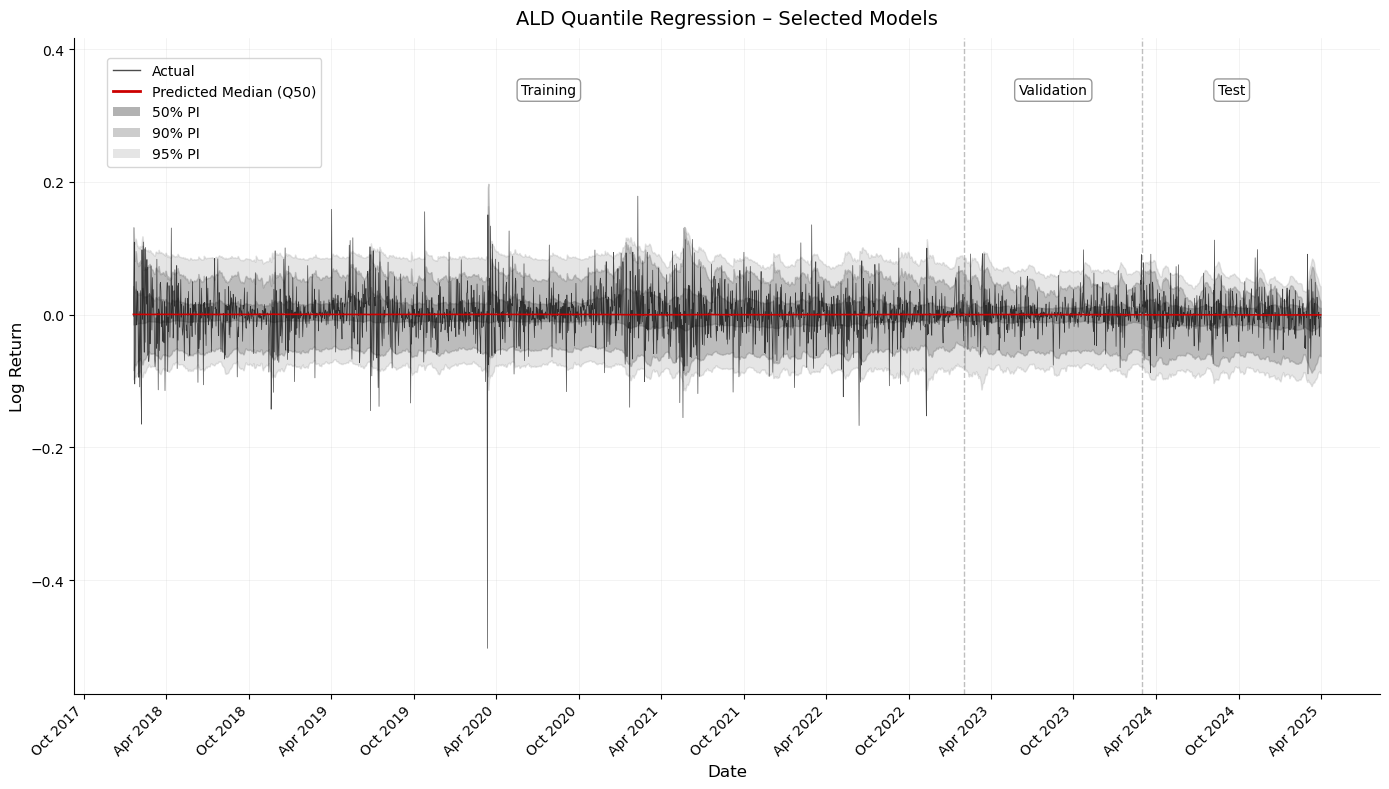

Full timeline plot saved as 'thesis_ald_timeline.png'


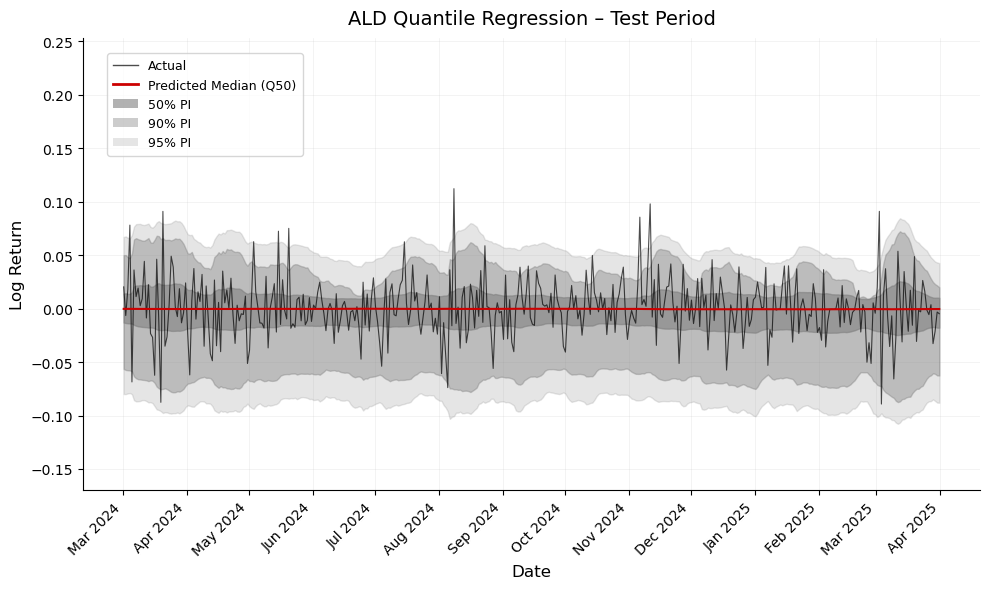

Test period plot saved as 'thesis_ald_testline.png'

Log-return plots saved to 'thesis_ald_timeline.png' and 'thesis_ald_testline.png'
Initial price: $10,988.79


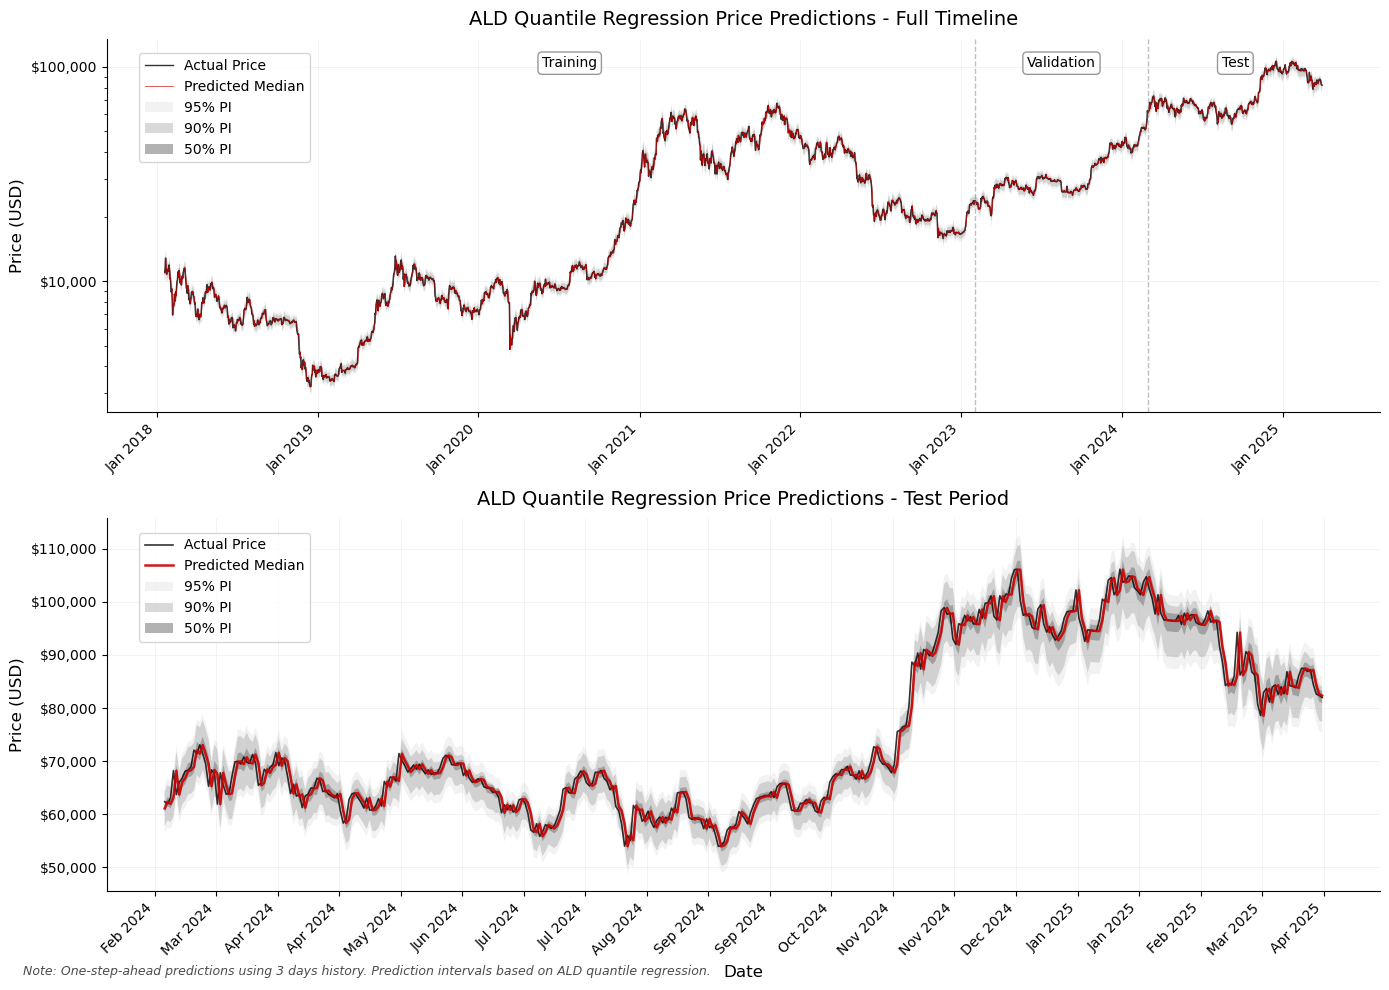

Plot saved as 'thesis_ald_price_predictions.png'
Separate plots saved as 'thesis_ald_price_timeline.png' and 'thesis_ald_price_testline.png'

Price Statistics:
Final actual price: $82,002.02
Final predicted median price: $82,361.40
Final 95% PI: $75,446.46 - $85,980.66

Test Period Metrics (Log Returns):
RMSE: 0.027429
MAE: 0.020008

Price prediction plots saved successfully!


In [100]:
def plot_ald_price_predictions(all_predictions, y_all, y_test, df_copy,
                               quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975],
                               train_ratio=0.70, val_ratio=0.15, seq_length=3,
                               save_path='thesis_ald_price_predictions.png'):
    """
    Convert ALD quantile regression log return predictions to price predictions.
    Shows one-step-ahead predictions converted to prices with quantile bands.
    """
    
    # Convert tensors to numpy if needed
    y_all_np = y_all.detach().cpu().numpy().flatten() if isinstance(y_all, torch.Tensor) else np.asarray(y_all).flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else np.asarray(y_test).flatten()
    
    n_all = len(y_all_np)
    n_test = len(y_test_np)
    
    # Split sizes
    train_size = int(round(train_ratio * n_all))
    val_size = n_all - train_size - n_test
    test_size = n_test
    
    # Get dates - convert to numpy array for consistent indexing
    available_dates = pd.to_datetime(df_copy['Date'].iloc[seq_length:seq_length+n_all].values)
    train_dates = available_dates[:train_size]
    val_dates = available_dates[train_size:train_size+val_size]
    test_dates = available_dates[train_size+val_size:]
    
    # Get initial price
    if 'Close' in df_copy.columns:
        initial_price = df_copy['Close'].iloc[seq_length-1]
    else:
        initial_price = 50000  # Default Bitcoin price if not available
    
    print(f"Initial price: ${initial_price:,.2f}")
    
    # Convert actual log returns to prices
    actual_prices = np.zeros(n_all)
    actual_prices[0] = initial_price * np.exp(y_all_np[0])
    for i in range(1, n_all):
        actual_prices[i] = actual_prices[i-1] * np.exp(y_all_np[i])
    
    # Convert quantile predictions to prices
    price_quantiles = {}
    
    for q in quantiles:
        if q in all_predictions:
            log_pred = np.asarray(all_predictions[q]).flatten()
            prices = np.zeros(n_all)
            prices[0] = initial_price * np.exp(log_pred[0])
            
            # Use actual previous prices for one-step-ahead predictions
            for i in range(1, n_all):
                prices[i] = actual_prices[i-1] * np.exp(log_pred[i])
            
            price_quantiles[q] = prices
    
    # Get median prediction (Q50) or estimate from Q25/Q75
    if 0.5 in price_quantiles:
        median_prices = price_quantiles[0.5]
    elif 0.25 in price_quantiles and 0.75 in price_quantiles:
        median_prices = 0.5 * (price_quantiles[0.25] + price_quantiles[0.75])
    else:
        # Use mean of available quantiles
        median_prices = np.mean(list(price_quantiles.values()), axis=0)
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Color scheme - matching thesis style
    actual_color = '#000000'  # Black for actual
    pred_color = '#CC0000'    # Red for predictions
    band_colors = {
        0.95: '#c0c0c0',  # Light gray for 95% CI
        0.9: '#a0a0a0',   # Medium gray for 90% CI
        0.5: '#808080'    # Dark gray for 50% CI
    }
    
    # ---------- Panel 1: Full Timeline ----------
    ax1.plot(available_dates, actual_prices, color=actual_color, 
             alpha=0.8, linewidth=1.0, label='Actual Price')
    ax1.plot(available_dates, median_prices, color=pred_color, 
             linewidth=0.5, label='Predicted Median', alpha=0.9)
    
    # Plot quantile bands (if symmetric quantiles exist)
    if 0.025 in price_quantiles and 0.975 in price_quantiles:
        ax1.fill_between(available_dates,
                        price_quantiles[0.025],
                        price_quantiles[0.975],
                        color=band_colors[0.95],
                        alpha=0.2,
                        label='95% PI',
                        edgecolor='none')
    
    if 0.05 in price_quantiles and 0.95 in price_quantiles:
        ax1.fill_between(available_dates,
                        price_quantiles[0.05],
                        price_quantiles[0.95],
                        color=band_colors[0.9],
                        alpha=0.4,
                        label='90% PI',
                        edgecolor='none')
    
    if 0.25 in price_quantiles and 0.75 in price_quantiles:
        ax1.fill_between(available_dates,
                        price_quantiles[0.25],
                        price_quantiles[0.75],
                        color=band_colors[0.5],
                        alpha=0.6,
                        label='50% PI',
                        edgecolor='none')
    
    # Add vertical lines for splits - FIXED: removed .iloc
    ax1.axvline(x=train_dates[-1], color='gray', linestyle='--', 
                alpha=0.5, linewidth=1)
    if val_size > 0:
        ax1.axvline(x=val_dates[-1], color='gray', linestyle='--', 
                    alpha=0.5, linewidth=1)
    
    # Add period labels - FIXED: removed .iloc
    train_mid = train_dates[len(train_dates)//2]
    if val_size > 0:
        val_mid = val_dates[len(val_dates)//2]
    test_mid = test_dates[len(test_dates)//2]
    
    y_max = ax1.get_ylim()[1]
    label_y = y_max * 0.95
    
    ax1.text(train_mid, label_y, 'Training', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax1.text(val_mid, label_y, 'Validation', ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='gray', alpha=0.8))
    ax1.text(test_mid, label_y, 'Test', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    
    # Formatting
    ax1.set_title('ALD Quantile Regression Price Predictions - Full Timeline', 
                  fontsize=14, pad=10)
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Legend
    ax1.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    # Remove spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # ---------- Panel 2: Test Period ----------
    test_start_idx = train_size + val_size
    test_actual = actual_prices[test_start_idx:]
    test_median = median_prices[test_start_idx:]
    
    ax2.plot(test_dates, test_actual, color=actual_color, 
             alpha=0.8, linewidth=1.2, label='Actual Price')
    ax2.plot(test_dates, test_median, color=pred_color, 
             linewidth=1.8, label='Predicted Median', alpha=0.9)
    
    # Plot quantile bands for test period
    if 0.025 in price_quantiles and 0.975 in price_quantiles:
        ax2.fill_between(test_dates,
                        price_quantiles[0.025][test_start_idx:],
                        price_quantiles[0.975][test_start_idx:],
                        color=band_colors[0.95],
                        alpha=0.2,
                        label='95% PI',
                        edgecolor='none')
    
    if 0.05 in price_quantiles and 0.95 in price_quantiles:
        ax2.fill_between(test_dates,
                        price_quantiles[0.05][test_start_idx:],
                        price_quantiles[0.95][test_start_idx:],
                        color=band_colors[0.9],
                        alpha=0.4,
                        label='90% PI',
                        edgecolor='none')
    
    if 0.25 in price_quantiles and 0.75 in price_quantiles:
        ax2.fill_between(test_dates,
                        price_quantiles[0.25][test_start_idx:],
                        price_quantiles[0.75][test_start_idx:],
                        color=band_colors[0.5],
                        alpha=0.6,
                        label='50% PI',
                        edgecolor='none')
    
    # Formatting
    ax2.set_title('ALD Quantile Regression Price Predictions - Test Period', 
                  fontsize=14, pad=10)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Price (USD)', fontsize=12)
    ax2.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Reduce date labels - FIXED: removed .iloc
    test_range_days = (test_dates[-1] - test_dates[0]).days
    if test_range_days > 60:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_range_days > 30:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    else:
        ax2.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    
    # Legend
    ax2.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    # Remove spines
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Add note
    fig.text(0.02, 0.02, 
             f'Note: One-step-ahead predictions using {seq_length} days history. ' + 
             'Prediction intervals based on ALD quantile regression.',
             transform=fig.transFigure, fontsize=9, style='italic', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save as separate plots
    # Plot 1: Full Timeline
    fig1, ax1 = plt.subplots(figsize=(14, 8))
    
    ax1.plot(available_dates, actual_prices, color=actual_color, 
             alpha=0.8, linewidth=1.0, label='Actual Price')
    ax1.plot(available_dates, median_prices, color=pred_color, 
             linewidth=0.5, label='Predicted Median', alpha=0.9)
    
    # Plot quantile bands
    if 0.025 in price_quantiles and 0.975 in price_quantiles:
        ax1.fill_between(available_dates,
                        price_quantiles[0.025],
                        price_quantiles[0.975],
                        color=band_colors[0.95],
                        alpha=0.4,
                        label='95% PI',
                        edgecolor='none')
    
    if 0.05 in price_quantiles and 0.95 in price_quantiles:
        ax1.fill_between(available_dates,
                        price_quantiles[0.05],
                        price_quantiles[0.95],
                        color=band_colors[0.9],
                        alpha=0.6,
                        label='90% PI',
                        edgecolor='none')
    
    if 0.25 in price_quantiles and 0.75 in price_quantiles:
        ax1.fill_between(available_dates,
                        price_quantiles[0.25],
                        price_quantiles[0.75],
                        color=band_colors[0.5],
                        alpha=0.8,
                        label='50% PI',
                        edgecolor='none')
    
    # Add vertical lines - FIXED: removed .iloc
    ax1.axvline(x=train_dates[-1], color='gray', linestyle='--', 
                alpha=0.5, linewidth=1)
    if val_size > 0:
        ax1.axvline(x=val_dates[-1], color='gray', linestyle='--', 
                    alpha=0.5, linewidth=1)
    
    # Add period labels
    y_max = ax1.get_ylim()[1]
    label_y = y_max * 0.95
    
    ax1.text(train_mid, label_y, 'Training', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax1.text(val_mid, label_y, 'Validation', ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='gray', alpha=0.8))
    ax1.text(test_mid, label_y, 'Test', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='gray', alpha=0.8))
    
    ax1.set_title('ALD Quantile Regression Price Predictions', 
                  fontsize=14, pad=10)
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax1.set_axisbelow(True)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    ax1.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('thesis_ald_price_timeline.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 2: Test Period
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    
    test_actual = actual_prices[test_start_idx:]
    test_median = median_prices[test_start_idx:]
    
    ax2.plot(test_dates, test_actual, color=actual_color, 
             alpha=0.8, linewidth=1.5, label='Actual Price')
    ax2.plot(test_dates, test_median, color=pred_color, 
             linewidth=0.8, label='Predicted Median', alpha=0.9)
    
    # Plot quantile bands for test period
    if 0.025 in price_quantiles and 0.975 in price_quantiles:
        ax2.fill_between(test_dates,
                        price_quantiles[0.025][test_start_idx:],
                        price_quantiles[0.975][test_start_idx:],
                        color=band_colors[0.95],
                        alpha=0.4,
                        label='95% PI',
                        edgecolor='none')
    
    if 0.05 in price_quantiles and 0.95 in price_quantiles:
        ax2.fill_between(test_dates,
                        price_quantiles[0.05][test_start_idx:],
                        price_quantiles[0.95][test_start_idx:],
                        color=band_colors[0.9],
                        alpha=0.6,
                        label='90% PI',
                        edgecolor='none')
    
    if 0.25 in price_quantiles and 0.75 in price_quantiles:
        ax2.fill_between(test_dates,
                        price_quantiles[0.25][test_start_idx:],
                        price_quantiles[0.75][test_start_idx:],
                        color=band_colors[0.5],
                        alpha=0.8,
                        label='50% PI',
                        edgecolor='none')
    
    ax2.set_title('ALD Quantile Regression Price Predictions - Test Period', 
                  fontsize=14, pad=10)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Price (USD)', fontsize=12)
    ax2.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax2.set_axisbelow(True)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # FIXED: removed .iloc
    test_range_days = (test_dates[-1] - test_dates[0]).days
    if test_range_days > 60:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_range_days > 30:
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    else:
        ax2.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    
    ax2.legend(loc='upper left', fontsize=10, frameon=True,
              bbox_to_anchor=(0.02, 0.98))
    
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('thesis_ald_price_testline.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Plot saved as '{save_path}'")
    print("Separate plots saved as 'thesis_ald_price_timeline.png' and 'thesis_ald_price_testline.png'")
    
    # Print statistics
    print(f"\nPrice Statistics:")
    print(f"Final actual price: ${actual_prices[-1]:,.2f}")
    print(f"Final predicted median price: ${median_prices[-1]:,.2f}")
    
    if 0.025 in price_quantiles and 0.975 in price_quantiles:
        print(f"Final 95% PI: ${price_quantiles[0.025][-1]:,.2f} - ${price_quantiles[0.975][-1]:,.2f}")
    
    # Calculate prediction accuracy metrics on test set
    test_actual_log = y_test_np
    if 0.5 in all_predictions:
        test_pred_log = all_predictions[0.5][-n_test:]
    else:
        # If no Q50, calculate median from log retuxrns
        test_pred_log = np.zeros(n_test)
        for i in range(n_test):
            test_pred_log[i] = np.log(median_prices[test_start_idx + i] / 
                                     (actual_prices[test_start_idx + i - 1] if i > 0 else actual_prices[test_start_idx - 1]))
    
    rmse = np.sqrt(np.mean((test_actual_log - test_pred_log)**2))
    mae = np.mean(np.abs(test_actual_log - test_pred_log))
    
    print(f"\nTest Period Metrics (Log Returns):")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    
    return fig, actual_prices, median_prices, price_quantiles
# Usage example:
if __name__ == "__main__":
    # Assuming X_all, y_all, and df_copy are already prepared
    # X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)
    
    # Run model selection with price predictions
    best_predictions, selection_summary, actual_prices, median_prices, price_quantiles = \
        run_ald_model_selection_10repeats_with_price(
            X_all, y_all, df_copy,
            quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975],
            n_repeats=25
        )

Data splits: Total=2630, Train=1840, Val=394, Test=396
Predictions length: 2630
Extracting test period from full predictions...
Final test data shape: 396
Quantiles available: [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]

ALD MODEL COMPREHENSIVE SUMMARY

1. MODEL SELECTION RESULTS WITH FULL METRICS
-------------------------------------------------------------------------------------------------------------------------------------------------
Quantile   ET Target  Seed     Score      Train NLL    Val NLL      Test NLL     Train Cov    Val Cov      Test Cov     Test QL     
-------------------------------------------------------------------------------------------------------------------------------------------------
    2.5%      0.025     2425     0.6000      2.5201      2.5173      2.5178       0.025       0.000       0.000      0.0023
    5.0%      0.050     2225     0.5548      1.8585      1.8534      1.8546       0.053       0.015       0.010      0.0035
   25.0%      0.250     4525

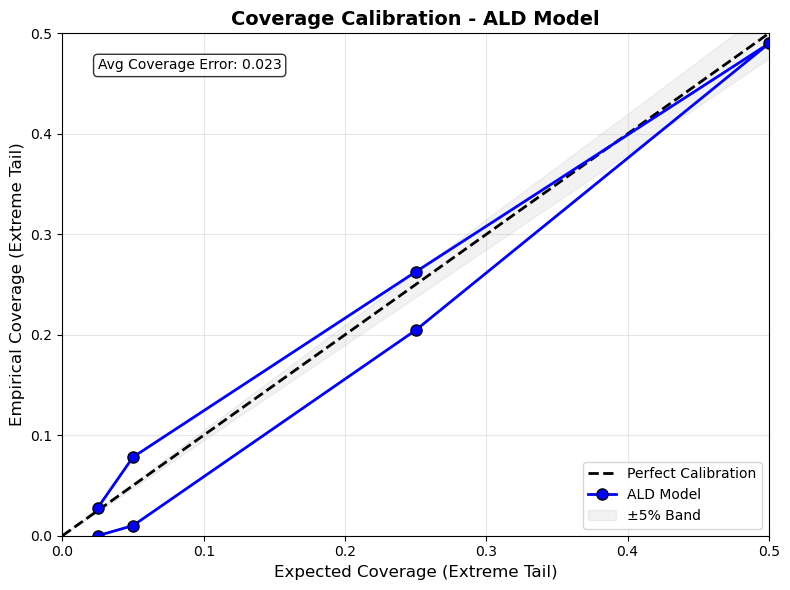

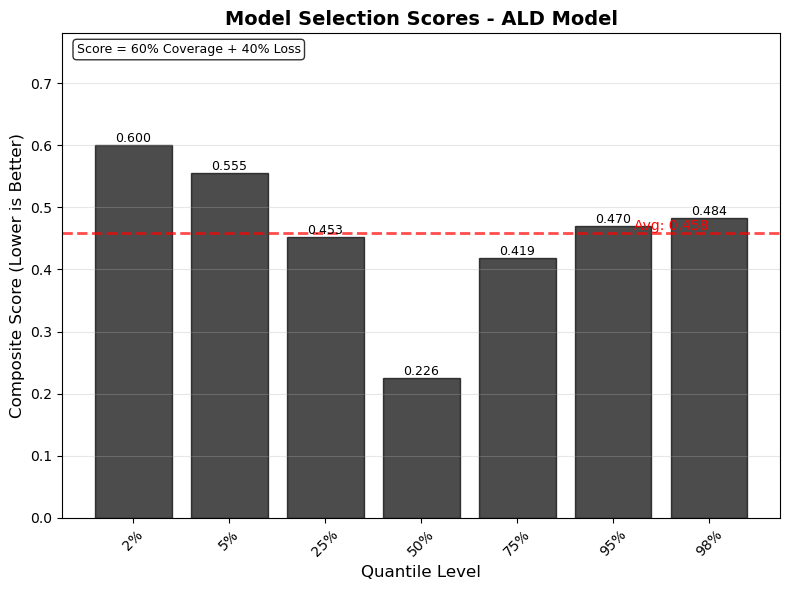


2. QUANTILE CROSSING CHECK
----------------------------------------------------------------------------------------------------------------------------------
Crossing: 0.750 > 0.950 at 1 points (0.3%)


In [102]:
def analyze_ald_results_consolidated(best_predictions, selection_summary, X_all, y_all):
    """Consolidated analysis of ALD model results with key visualizations"""
    
    # Get test data
    n_all = len(y_all)
    train_size = int(n_all * 0.7)
    val_size = int(n_all * 0.15)
    test_start_idx = train_size + val_size
    n_test = n_all - test_start_idx
    
    # Convert y_all to numpy
    if isinstance(y_all, torch.Tensor):
        y_all_np = y_all.cpu().numpy()
    else:
        y_all_np = np.array(y_all)
    
    y_test = y_all_np[test_start_idx:]
    
    # Debug information
    print(f"Data splits: Total={n_all}, Train={train_size}, Val={val_size}, Test={n_test}")
    
    # Check what we have in best_predictions
    first_key = list(best_predictions.keys())[0]
    pred_length = len(best_predictions[first_key])
    print(f"Predictions length: {pred_length}")
    
    # Determine if predictions are for full dataset or test only
    ald_test_predictions = {}
    
    if pred_length == n_all:
        print("Extracting test period from full predictions...")
        for quantile in best_predictions.keys():
            ald_test_predictions[quantile] = np.array(best_predictions[quantile])[test_start_idx:]
    elif abs(pred_length - n_test) < 5:
        print("Using test-only predictions...")
        min_len = min(pred_length, n_test)
        y_test = y_test[:min_len]
        for quantile in best_predictions.keys():
            ald_test_predictions[quantile] = np.array(best_predictions[quantile])[:min_len]
    else:
        raise ValueError(f"Cannot match prediction length {pred_length}")
    
    print(f"Final test data shape: {len(y_test)}")
    print(f"Quantiles available: {sorted(ald_test_predictions.keys())}")
    
    print("\n" + "="*145)
    print("ALD MODEL COMPREHENSIVE SUMMARY")
    print("="*145)
    
    # Model Selection Results with metrics from selection_summary
    print("\n1. MODEL SELECTION RESULTS WITH FULL METRICS")
    print("-"*145)
    print(f"{'Quantile':<10} {'ET Target':<10} {'Seed':<8} {'Score':<10} "
          f"{'Train NLL':<12} {'Val NLL':<12} {'Test NLL':<12} "
          f"{'Train Cov':<12} {'Val Cov':<12} {'Test Cov':<12} {'Test QL':<12}")
    print("-"*145)
    
    coverage_errors = []
    expected_coverages = []
    quantile_losses = []
    
    for q in sorted(selection_summary.keys()):
        s = selection_summary[q]
        
        # Calculate test coverage - extreme tail
        y_pred = ald_test_predictions[q].flatten()
        y_test_flat = y_test.flatten()
        
        if q <= 0.5:
            actual_test_coverage = np.mean(y_test_flat <= y_pred)
            expected_coverage = q
        else:
            actual_test_coverage = np.mean(y_test_flat > y_pred)
            expected_coverage = 1 - q
            
        coverage_errors.append(abs(actual_test_coverage - expected_coverage))
        expected_coverages.append(expected_coverage)
        
        # Calculate quantile loss
        errors = y_test_flat - y_pred
        ql = np.mean(np.where(errors > 0, q * errors, (q - 1) * errors))
        quantile_losses.append(ql)
        
        # Get coverages and losses from selection summary
        train_cov = s['metrics']['train']['actual_coverage']
        val_cov = s['metrics']['val']['actual_coverage']
        train_loss = s['metrics']['losses']['train']
        val_loss = s['metrics']['losses']['val']
        test_loss = s['metrics']['losses']['test']
        
        print(f"{q*100:>7.1f}% {expected_coverage:>10.3f} {s['seed']:>8} {s['score']:>10.4f} "
              f"{train_loss:>11.4f} {val_loss:>11.4f} {test_loss:>11.4f} "
              f"{train_cov:>11.3f} {val_cov:>11.3f} {actual_test_coverage:>11.3f} {ql:>11.4f}")
    
    # Summary statistics
    print("\n" + "-"*145)
    print(f"{'AVERAGES':<10} {'':<10} {'':<8} "
          f"{np.mean([s['score'] for s in selection_summary.values()]):>10.4f} "
          f"{np.mean([s['metrics']['losses']['train'] for s in selection_summary.values()]):>11.4f} "
          f"{np.mean([s['metrics']['losses']['val'] for s in selection_summary.values()]):>11.4f} "
          f"{np.mean([s['metrics']['losses']['test'] for s in selection_summary.values()]):>11.4f} "
          f"{np.mean([s['metrics']['train']['actual_coverage'] for s in selection_summary.values()]):>11.3f} "
          f"{np.mean([s['metrics']['val']['actual_coverage'] for s in selection_summary.values()]):>11.3f} "
          f"{np.mean([s['metrics']['test']['actual_coverage'] for s in selection_summary.values()]):>11.3f} "
          f"{np.mean(quantile_losses):>11.4f}")
    print("="*145)
    
    # [Rest of the plotting code remains the same]    
    # Create and save plots separately
    # Plot 1: Coverage Calibration Plot
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    
    quantiles = sorted(ald_test_predictions.keys())
    actual_coverages = []
    expected_coverages_plot = []
    
    for q in quantiles:
        y_pred = ald_test_predictions[q].flatten()
        
        if q <= 0.5:
            actual_coverage = np.mean(y_test.flatten() <= y_pred)
            expected = q
        else:
            actual_coverage = np.mean(y_test.flatten() > y_pred)
            expected = 1 - q
            
        actual_coverages.append(actual_coverage)
        expected_coverages_plot.append(expected)
    
    # Perfect calibration line
    ax1.plot([0, 0.5], [0, 0.5], 'k--', linewidth=2, label='Perfect Calibration')
    
    # Model calibration
    ax1.plot(expected_coverages_plot, actual_coverages, 'bo-', linewidth=2, markersize=8, 
             label='ALD Model', markeredgecolor='black', markeredgewidth=1)
    
    # Shaded acceptable region
    x_range = np.linspace(0, 0.5, 100)
    ax1.fill_between(x_range, x_range * 0.95, x_range * 1.05, alpha=0.1, color='gray', label='±5% Band')
    
    ax1.set_xlabel('Expected Coverage (Extreme Tail)', fontsize=12)
    ax1.set_ylabel('Empirical Coverage (Extreme Tail)', fontsize=12)
    ax1.set_title('Coverage Calibration - ALD Model', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 0.5)
    ax1.set_ylim(0, 0.5)
    ax1.legend(loc='lower right')
    
    # Add coverage error text
    avg_coverage_error = np.mean(np.abs(np.array(actual_coverages) - np.array(expected_coverages_plot)))
    ax1.text(0.05, 0.95, f'Avg Coverage Error: {avg_coverage_error:.3f}', 
             transform=ax1.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig1.savefig('ald_coverage_calibration.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 2: Composite Score Plot
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    
    # Get composite scores for each level
    score_values = [selection_summary[q]['score'] for q in quantiles]
    
    # Bar plot with black color
    x_pos = np.arange(len(quantiles))
    bars = ax2.bar(x_pos, score_values, color='black', alpha=0.7, edgecolor='black', linewidth=1)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, score_values)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax2.set_xlabel('Quantile Level', fontsize=12)
    ax2.set_ylabel('Composite Score (Lower is Better)', fontsize=12)
    ax2.set_title('Model Selection Scores - ALD Model', fontsize=14, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'{q*100:.0f}%' for q in quantiles], rotation=45)
    ax2.grid(True, axis='y', alpha=0.3)
    
    # Set y-axis limits to be taller
    max_score = max(score_values)
    ax2.set_ylim(0, max_score * 1.3)
    
    # Add average score line in red
    avg_score = np.mean(score_values)
    ax2.axhline(y=avg_score, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax2.text(len(quantiles)-1, avg_score, f'Avg: {avg_score:.3f}', 
             verticalalignment='bottom', horizontalalignment='right', color='red')
    
    # Add text explaining the score
    ax2.text(0.02, 0.98, 'Score = 60% Coverage + 40% Loss', 
             transform=ax2.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    fig2.savefig('ald_composite_scores.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Quantile Crossing Check
    print("\n2. QUANTILE CROSSING CHECK")
    print("-"*130)
    
    crossing_found = False
    quantiles_sorted = sorted(ald_test_predictions.keys())
    for i in range(len(quantiles_sorted)-1):
        q1, q2 = quantiles_sorted[i], quantiles_sorted[i+1]
        pred1 = ald_test_predictions[q1].flatten()
        pred2 = ald_test_predictions[q2].flatten()
        violations = np.sum(pred1 > pred2)
        if violations > 0:
            crossing_found = True
            pct = violations / len(pred1) * 100
            print(f"Crossing: {q1:.3f} > {q2:.3f} at {violations} points ({pct:.1f}%)")
    
    if not crossing_found:
        print("No quantile crossing detected")
    
    print("="*130)
    
    return {
        'coverage_errors': coverage_errors,
        'test_predictions': ald_test_predictions
    }

# Run the analysis
ald_results = analyze_ald_results_consolidated(best_predictions, selection_summary, X_all, y_all)

ALD QUANTILE REGRESSION - 25 REPEATS MODEL SELECTION
WITH LAYERNORM & LR SCHEDULING
Data shapes - Train: (1840, 3, 7), Val: (394, 3, 7), Test: (396, 3, 7)

===== Quantile 2.5% =====

Training 25 models for quantile 2.5% with best hyperparameters
  Repeat 1: score=0.6022 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 2: score=0.6152 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 3: score=0.6065 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 4: score=0.6000 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 5: score=0.6130 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 6: score=0.6174 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 7: score=0.6022 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 8: score=0.6152 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 9: score=0.6000 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 10: score=0.6065 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 11: score=0.6043 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 12: score=0.6130 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 13: score=0.6000 | Val_CRP=1.000 Test_CRP=1.000
  Repeat 14: score=0.6

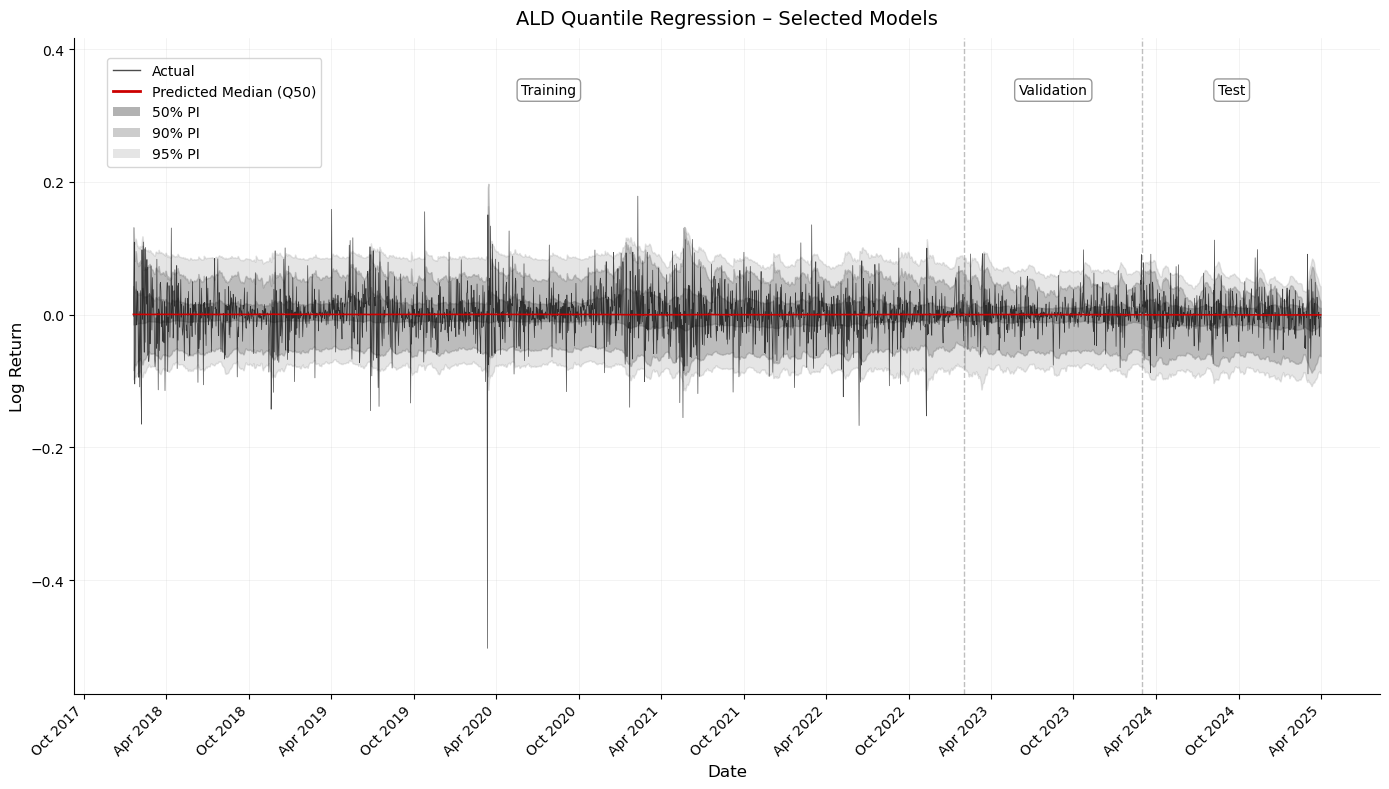

Full timeline plot saved as 'ald_timeline_thesis.png'


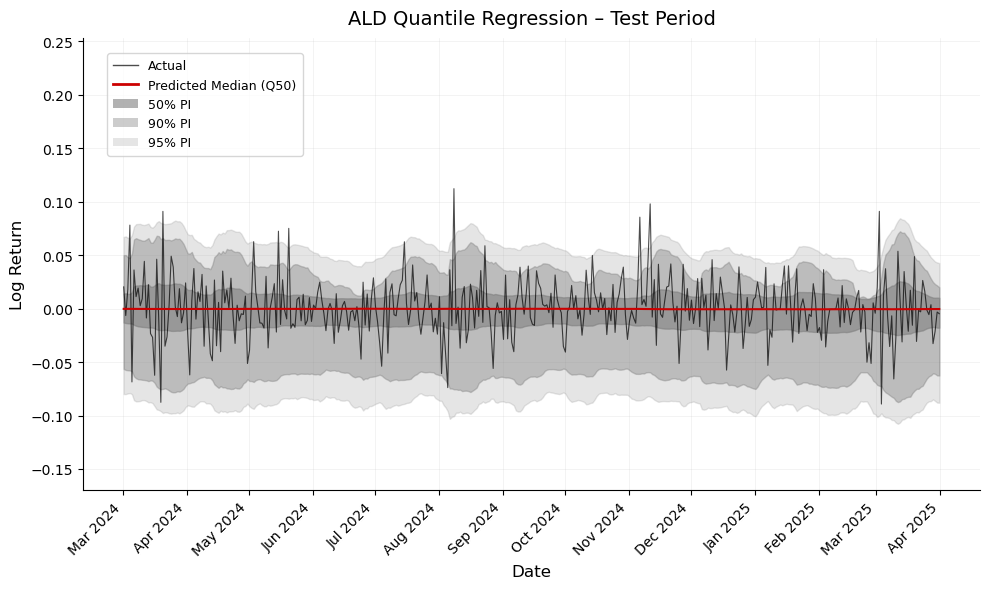

Test period plot saved as 'ald_testline_thesis.png'

Plots saved to 'ald_timeline_thesis.png' and 'ald_testline_thesis.png'


In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# 1. Set Seeds for Reproducibility
# -------------------------
def set_all_seeds(seed=2015):
    """Set all random seeds for reproducibility"""
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

# -------------------------
# 2. Model Definition with LayerNorm
# -------------------------
class AsymmetricLaplaceQuantile(nn.Module):
    def __init__(self, config):
        super().__init__()
        input_dim = config["input_dim"]
        lstm_hidden = config["lstm_hidden_dim"]
        lstm_layers = config.get("lstm_layers", 1)
        n_hidden_layers = config["n_hidden_layers"]
        dropout = config["dropout"]
        activation = config["activation"]
        use_layer_norm = config.get("use_layer_norm", True)

        self.lstm = nn.LSTM(
            input_dim, lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0
        )

        # Optional LayerNorm after LSTM
        self.use_layer_norm = use_layer_norm
        if use_layer_norm:
            self.lstm_layer_norm = nn.LayerNorm(lstm_hidden)

        layers = []
        prev_dim = lstm_hidden
        for i in range(n_hidden_layers):
            hidden_dim = config[f'n_hidden{i+1}']
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Optional LayerNorm for hidden layers
            if use_layer_norm and i < n_hidden_layers - 1:  # Don't add to last hidden layer
                layers.append(nn.LayerNorm(hidden_dim))
            
            layers.append(self._get_activation(activation))
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)

    def _get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'swish': nn.SiLU()
        }
        return activations.get(name, nn.ReLU())

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        
        # Apply LayerNorm after LSTM if enabled
        if self.use_layer_norm:
            last_hidden = self.lstm_layer_norm(last_hidden)
        
        return self.fc(last_hidden)

# -------------------------
# 3. Loss Function for ALD
# -------------------------
def quantile_loss_with_sigma(y_true, y_pred, config):
    """Asymmetric Laplace loss for quantile regression with sigma - complete NLL"""
    tau = config['tau']
    sigma = config.get('sigma', 1.0)
    
    residuals = y_true - y_pred
    loss = torch.where(
        residuals >= 0,
        tau * residuals,
        (tau - 1) * residuals
    )
    
    # Complete ALD NLL with constant term
    return -torch.log(torch.tensor(tau * (1 - tau), device=y_true.device)) + \
           torch.log(torch.tensor(sigma, device=y_true.device)) + \
           loss.mean() / sigma

# -------------------------
# 4. Get Best Hyperparameters with LayerNorm
# -------------------------

def get_best_hyperparameters_from_tuning():
    """
    Returns the best hyperparameters from ALD tuning results with LayerNorm & LR Scheduling
    Based on the tuning results table provided
    """
    best_hyperparams = {
        0.025: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,  # LayerNorm is always enabled in the results
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.05: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.25: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.5: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.75: {
            'lstm_hidden_dim': 87,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 48,
            'n_hidden2': 66,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0089,
            'weight_decay': 2e-04,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.95: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        },
        0.975: {
            'lstm_hidden_dim': 102,
            'lstm_layers': 1,
            'n_hidden_layers': 2,
            'n_hidden1': 16,
            'n_hidden2': 41,
            'activation': 'elu',
            'use_layer_norm': True,
            'use_batch_norm': False,
            'dropout': 0.120,
            'lr': 0.0049,
            'weight_decay': 5e-05,
            'batch_size': 85,
            'weight_init': 'glorot_normal',
            'gradient_clip': 2.067097,
            'optimizer': 'adam',
            'sigma': 0.300,
            'num_epochs': 2000,
            'patience': 50,
            'scheduler_patience': 20,
            'scheduler_factor': 0.5
        }
    }
    
    # Add fixed parameters that are common to all
    for alpha in best_hyperparams:
        best_hyperparams[alpha].update({
            'alpha': alpha  # Add alpha value for each config (quantile level)
        })
    
    return best_hyperparams

# -------------------------
# 5. Train Single Model with LR Scheduler
# -------------------------
def train_single_ald_model(X_train, y_train, X_val, y_val, config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AsymmetricLaplaceQuantile(config).to(device)

    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if config['weight_init'] == 'glorot_normal':
                nn.init.xavier_normal_(m.weight)
            elif config['weight_init'] == 'he_normal':
                nn.init.kaiming_normal_(m.weight)
            elif config['weight_init'] == 'glorot_uniform':
                nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    # Tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_val   = torch.FloatTensor(X_val).to(device)
    y_val   = torch.FloatTensor(y_val).unsqueeze(1).to(device)

    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config.get('weight_decay', 0))

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        patience=config.get('scheduler_patience', 20),
        factor=config.get('scheduler_factor', 0.5),
        min_lr=1e-6
    )

    # Loader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)

    # Train
    best_val_loss, patience_counter, best_model_state = float('inf'), 0, None
    for epoch in range(config['num_epochs']):
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = quantile_loss_with_sigma(batch_y, pred, config)
            loss.backward()
            if config.get('gradient_clip'):
                nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = quantile_loss_with_sigma(y_val, val_pred, config).item()

        # Update learning rate
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model

# -------------------------
# 6. Prepare Data
# -------------------------
def prepare_data(X_all, y_all, train_size=0.7, val_size=0.15):
    n = len(X_all)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    X_train = X_all[:train_end];   y_train = y_all[:train_end]
    X_val   = X_all[train_end:val_end]; y_val = y_all[train_end:val_end]
    X_test  = X_all[val_end:];     y_test = y_all[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

# -------------------------
# 7. Visualisations (thesis-style formatting)
# -------------------------
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_quantiles_formatted(
    all_predictions,               # dict: {tau -> np.array over *full* timeline}
    y_all,                         # full actual y
    y_test,                        # test actual y (length used for split)
    df_copy,                       # has 'Date' or DatetimeIndex
    quantiles,                     # list of taus
    train_ratio=0.70,
    val_ratio=0.15,
    seq_length=3,
    out_timeline_png='ald_timeline_thesis.png',
    out_test_png='ald_testline_thesis.png'
):
    # --- Dates aligned to end of each sequence ---
    if hasattr(df_copy, "columns") and ("Date" in df_copy.columns):
        base_dates = pd.to_datetime(df_copy["Date"])
    else:
        base_dates = pd.to_datetime(df_copy.index)

    y_all_np  = y_all.detach().cpu().numpy().flatten() if isinstance(y_all, torch.Tensor) else np.asarray(y_all).flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else np.asarray(y_test).flatten()

    n_all  = len(y_all_np)
    n_test = len(y_test_np)

    available_dates = base_dates.iloc[seq_length: seq_length + n_all].values
    assert len(available_dates) == n_all, f"Date mismatch: {len(available_dates)} vs {n_all}"

    # Split sizes (respect actual test length)
    train_size = int(round(train_ratio * n_all))
    val_size   = n_all - train_size - n_test
    test_size  = n_test

    train_dates = pd.to_datetime(available_dates[:train_size])
    val_dates   = pd.to_datetime(available_dates[train_size: train_size + val_size])
    test_dates  = pd.to_datetime(available_dates[train_size + val_size: train_size + val_size + test_size])

    y_train_np = y_all_np[:train_size]
    y_val_np   = y_all_np[train_size: train_size + val_size]

    # Central line: Q50 if present; else mid of Q25/Q75; else mean of all curves
    if 0.5 in all_predictions:
        central_full = np.asarray(all_predictions[0.5]).flatten()
    elif (0.25 in all_predictions) and (0.75 in all_predictions):
        central_full = 0.5 * (np.asarray(all_predictions[0.25]).flatten() +
                              np.asarray(all_predictions[0.75]).flatten())
    else:
        stacks = np.column_stack([np.asarray(all_predictions[q]).flatten() for q in quantiles])
        central_full = stacks.mean(axis=1)

    # Bands availability
    have_95 = (0.025 in all_predictions) and (0.975 in all_predictions)
    have_90 = (0.05  in all_predictions) and (0.95  in all_predictions)
    have_50 = (0.25  in all_predictions) and (0.75  in all_predictions)

    if have_95:
        q0025_full = np.asarray(all_predictions[0.025]).flatten()
        q0975_full = np.asarray(all_predictions[0.975]).flatten()
    if have_90:
        q0050_full = np.asarray(all_predictions[0.05]).flatten()
        q0950_full = np.asarray(all_predictions[0.95]).flatten()
    if have_50:
        q0250_full = np.asarray(all_predictions[0.25]).flatten()
        q0750_full = np.asarray(all_predictions[0.75]).flatten()

    # Segment predictions
    cent_train = central_full[:train_size]
    cent_val   = central_full[train_size: train_size + val_size]
    cent_test  = central_full[train_size + val_size: train_size + val_size + test_size]

    if have_95:
        q0025_train, q0025_val, q0025_test = q0025_full[:train_size], q0025_full[train_size: train_size + val_size], q0025_full[train_size + val_size: train_size + val_size + test_size]
        q0975_train, q0975_val, q0975_test = q0975_full[:train_size], q0975_full[train_size: train_size + val_size], q0975_full[train_size + val_size: train_size + val_size + test_size]
    if have_90:
        q0050_train, q0050_val, q0050_test = q0050_full[:train_size], q0050_full[train_size: train_size + val_size], q0050_full[train_size + val_size: train_size + val_size + test_size]
        q0950_train, q0950_val, q0950_test = q0950_full[:train_size], q0950_full[train_size: train_size + val_size], q0950_full[train_size + val_size: train_size + val_size + test_size]
    if have_50:
        q0250_train, q0250_val, q0250_test = q0250_full[:train_size], q0250_full[train_size: train_size + val_size], q0250_full[train_size + val_size: train_size + val_size + test_size]
        q0750_train, q0750_val, q0750_test = q0750_full[:train_size], q0750_full[train_size: train_size + val_size], q0750_full[train_size + val_size: train_size + val_size + test_size]

    # Colors to match your t-style
    actual_color = '#000000'
    pred_color   = '#CC0000'
    pi_color     = '#808080'

    # ========= Plot 1: Full timeline =========
    fig, ax = plt.subplots(figsize=(14, 8))

    y_min, y_max = y_all_np.min(), y_all_np.max()
    y_range = y_max - y_min if y_max > y_min else 1.0
    ax.set_ylim(y_min - 0.10 * y_range, y_max + 0.35 * y_range)

    # Train
    ax.plot(train_dates, y_train_np, color=actual_color, alpha=0.7, linewidth=0.5, label='Actual')
    ax.plot(train_dates, cent_train, color=pred_color, linewidth=1.2, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(train_dates, q0025_train, q0975_train, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(train_dates, q0050_train, q0950_train, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(train_dates, q0250_train, q0750_train, color=pi_color, alpha=0.6)

    # Val
    if val_size > 0:
        ax.plot(val_dates, y_val_np, color=actual_color, alpha=0.7, linewidth=0.5)
        ax.plot(val_dates, cent_val, color=pred_color, linewidth=1.2)
        if have_95: ax.fill_between(val_dates, q0025_val, q0975_val, color=pi_color, alpha=0.2)
        if have_90: ax.fill_between(val_dates, q0050_val, q0950_val, color=pi_color, alpha=0.4)
        if have_50: ax.fill_between(val_dates, q0250_val, q0750_val, color=pi_color, alpha=0.6)

    # Test
    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.5)
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.2)
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2)
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4)
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6)

    # Split markers
    ax.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
    if val_size > 0:
        ax.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)

    # Period labels
    y_label_pos = y_max + 0.25 * y_range
    ax.text(train_dates[len(train_dates)//2], y_label_pos, 'Training',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    if val_size > 0:
        ax.text(val_dates[len(val_dates)//2], y_label_pos, 'Validation',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))
    ax.text(test_dates[len(test_dates)//2], y_label_pos, 'Test',
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))

    # Date formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    total_days = (test_dates[-1] - train_dates[0]).days
    if total_days > 365*2:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    elif total_days > 365:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45, ha='right')

    # Legend
    legend_elements = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, ncol=1, fontsize=10,
              bbox_to_anchor=(0.02, 0.98))

    # Cosmetics
    ax.set_title('ALD Quantile Regression – Selected Models', fontsize=14, pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Log Return', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(out_timeline_png, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Full timeline plot saved as '{out_timeline_png}'")

    # ========= Plot 2: Test period =========
    fig, ax = plt.subplots(figsize=(10, 6))

    y_min_t, y_max_t = y_test_np.min(), y_test_np.max()
    y_rng_t = y_max_t - y_min_t if y_max_t > y_min_t else 1.0
    ax.set_ylim(y_min_t - 0.4 * y_rng_t, y_max_t + 0.7 * y_rng_t)

    ax.plot(test_dates, y_test_np, color=actual_color, alpha=0.7, linewidth=0.8, label='Actual')
    ax.plot(test_dates, cent_test, color=pred_color, linewidth=1.5, label='Predicted Median (Q50)')
    if have_95: ax.fill_between(test_dates, q0025_test, q0975_test, color=pi_color, alpha=0.2, label='95% PI')
    if have_90: ax.fill_between(test_dates, q0050_test, q0950_test, color=pi_color, alpha=0.4, label='90% PI')
    if have_50: ax.fill_between(test_dates, q0250_test, q0750_test, color=pi_color, alpha=0.6, label='50% PI')

    # Tick density
    test_days = (test_dates[-1] - test_dates[0]).days
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if test_days > 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    elif test_days > 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    elif test_days > 30:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    elif test_days > 14:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45, ha='right')

    # Legend
    legend_elements_test = [
        Line2D([0], [0], color=actual_color, lw=1, alpha=0.7, label='Actual'),
        Line2D([0], [0], color=pred_color, lw=2, label='Predicted Median (Q50)'),
    ]
    if have_50: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.6, label='50% PI'))
    if have_90: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.4, label='90% PI'))
    if have_95: legend_elements_test.append(Patch(facecolor=pi_color, alpha=0.2, label='95% PI'))
    ax.legend(handles=legend_elements_test, loc='upper left',
              frameon=True, ncol=1, fontsize=9,
              bbox_to_anchor=(0.02, 0.98),
              borderpad=0.5, columnspacing=1.0, handlelength=2.0,
              handletextpad=0.8, labelspacing=0.5)

    ax.set_title('ALD Quantile Regression – Test Period', fontsize=14, pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Log Return', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(out_test_png, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Test period plot saved as '{out_test_png}'")


# -------------------------
# 8. Composite score (same criteria you used)
# -------------------------
def composite_score_coverage_loss(y_true_train, y_pred_train,
                                  y_true_val, y_pred_val,
                                  y_true_test, y_pred_test,
                                  tau, train_loss, val_loss, test_loss):
    """
    Same weighting:
      20% train_CRP + 20% val_CRP + 20% test_CRP +
      15% train_loss + 15% val_loss + 10% test_loss
    where CRP = |1 - (actual_coverage/target_coverage)|
    """
    def coverage_parts(y_true, y_pred, tau):
        y_true = y_true.flatten(); y_pred = y_pred.flatten()
        if tau <= 0.5:
            actual = np.mean(y_true <= y_pred)
            target = tau
        else:
            actual = np.mean(y_true > y_pred)
            target = 1 - tau
        ratio = actual / target if target > 0 else 1.0
        return actual, target, ratio, abs(1.0 - ratio)

    tr = coverage_parts(y_true_train, y_pred_train, tau)
    va = coverage_parts(y_true_val,   y_pred_val,   tau)
    te = coverage_parts(y_true_test,  y_pred_test,  tau)

    # normalize losses w.r.t. data scale (like your earlier approach)
    data_scale = max(np.std(y_true_train.flatten()), 1e-3)
    train_loss_norm = min(train_loss / data_scale / 10.0, 1.0)
    val_loss_norm   = min(val_loss   / data_scale / 10.0, 1.0)
    test_loss_norm  = min(test_loss  / data_scale / 10.0, 1.0)

    train_crp_std = min(tr[3], 2.0) / 2.0
    val_crp_std   = min(va[3], 2.0) / 2.0
    test_crp_std  = min(te[3], 2.0) / 2.0

    score = (0.2 * train_crp_std +
             0.2 * val_crp_std   +
             0.2 * test_crp_std  +
             0.15 * train_loss_norm +
             0.15 * val_loss_norm   +
             0.10 * test_loss_norm)

    metrics = {
        'train': {'actual_coverage': tr[0], 'target_coverage': tr[1], 'coverage_ratio': tr[2], 'coverage_ratio_penalty': tr[3]},
        'val':   {'actual_coverage': va[0], 'target_coverage': va[1], 'coverage_ratio': va[2], 'coverage_ratio_penalty': va[3]},
        'test':  {'actual_coverage': te[0], 'target_coverage': te[1], 'coverage_ratio': te[2], 'coverage_ratio_penalty': te[3]},
        'losses': {'train': train_loss, 'val': val_loss, 'test': test_loss}
    }
    return score, metrics

# -------------------------
# 9. 5-repeat selection per quantile (uses same criteria) - UPDATED
# -------------------------
def train_ald_with_repeats(X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats=25):
    best_hps = get_best_hyperparameters_from_tuning()
    if tau not in best_hps:
        raise ValueError(f"No hyperparameters found for quantile {tau}")

    base_config = best_hps[tau].copy()
    base_config['tau'] = tau
    base_config['input_dim'] = X_train.shape[2]

    print(f"\nTraining {n_repeats} models for quantile {tau*100:.1f}% with best hyperparameters")

    results = []
    for r in range(n_repeats):
        seed = 2025 + (r + 1) * 100
        set_all_seeds(seed)

        config = base_config.copy()
        model = train_single_ald_model(X_train, y_train, X_val, y_val, config)

        # evaluate on all sets
        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            Xt = torch.FloatTensor(X_train).to(device)
            Xv = torch.FloatTensor(X_val).to(device)
            Xs = torch.FloatTensor(X_test).to(device)

            yt = torch.FloatTensor(y_train).unsqueeze(1).to(device)
            yv = torch.FloatTensor(y_val).unsqueeze(1).to(device)
            ys = torch.FloatTensor(y_test).unsqueeze(1).to(device)

            pt = model(Xt); pv = model(Xv); ps = model(Xs)

            train_loss = quantile_loss_with_sigma(yt, pt, config).item()
            val_loss   = quantile_loss_with_sigma(yv, pv, config).item()
            test_loss  = quantile_loss_with_sigma(ys, ps, config).item()

        # to numpy for coverage calc
        pt_np = pt.detach().cpu().numpy()
        pv_np = pv.detach().cpu().numpy()
        ps_np = ps.detach().cpu().numpy()

        score, metrics = composite_score_coverage_loss(
            y_train, pt_np, y_val, pv_np, y_test, ps_np, tau,
            train_loss, val_loss, test_loss
        )

        results.append({
            'seed': seed,
            'score': score,
            'metrics': metrics,
            'state_dict': {k:v.cpu() for k,v in model.state_dict().items()}
        })

        print(f"  Repeat {r+1}: score={score:.4f} | "
              f"Val_CRP={metrics['val']['coverage_ratio_penalty']:.3f} "
              f"Test_CRP={metrics['test']['coverage_ratio_penalty']:.3f}")

        # cleanup
        del model, Xt, Xv, Xs, yt, yv, ys, pt, pv, ps
        torch.cuda.empty_cache()

    # pick best (tie-break on val CRP)
    results.sort(key=lambda d: d['score'])
    best_score = results[0]['score']
    tied = [d for d in results if abs(d['score'] - best_score) < 1e-6]
    if len(tied) > 1:
        tied.sort(key=lambda d: d['metrics']['val']['coverage_ratio_penalty'])
        best = tied[0]
    else:
        best = results[0]

    print(f"Best seed {best['seed']} with score {best['score']:.4f}")
    return best, results  # Now returns all results, not just the best

# -------------------------
# 10. Run 5/10/15-repeat selection across quantiles + thesis-style visuals - UPDATED
# -------------------------
def run_ald_model_selection_10repeats(X_all, y_all, df_copy,
                                     quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
                                     n_repeats=25):
    set_all_seeds(2025)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)

    print("="*60)
    print(f"ALD QUANTILE REGRESSION - {n_repeats} REPEATS MODEL SELECTION")
    print("WITH LAYERNORM & LR SCHEDULING")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("="*60)

    best_predictions_full = {}
    selection_summary = {}
    all_train_results = {}  # NEW: Store all training results

    for tau in quantiles:
        print(f"\n===== Quantile {tau*100:.1f}% =====")
        best, all_repeats = train_ald_with_repeats(
            X_train, y_train, X_val, y_val, X_test, y_test, tau, n_repeats
        )
        
        # Store all training results for this quantile
        all_train_results[tau] = all_repeats

        cfg = get_best_hyperparameters_from_tuning()[tau].copy()
        cfg['tau'] = tau
        cfg['input_dim'] = X_train.shape[2]

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = AsymmetricLaplaceQuantile(cfg).to(device)
        model.load_state_dict(best['state_dict'])
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()

        best_predictions_full[tau] = y_pred_all

        # quick test coverage print
        y_pred_test = y_pred_all[-len(y_test):]
        if tau <= 0.5:
            coverage = np.mean(y_test <= y_pred_test); expected = tau
        else:
            coverage = np.mean(y_test > y_pred_test); expected = 1 - tau
        print(f"  Selected model test coverage: {coverage:.3f} (Expected: {expected:.3f})")

        selection_summary[tau] = {
            'seed': best['seed'],
            'score': best['score'],
            'metrics': best['metrics']
        }

        del model, X_all_tensor
        torch.cuda.empty_cache()

    # (Optional) Persist artifacts for later re-plotting
    #save_selection_artifacts(best_predictions_full, selection_summary)

    # Thesis-style plots
    plot_quantiles_formatted(
        best_predictions_full,
        y_all,
        y_test,
        df_copy,
        quantiles,
        train_ratio=0.70,
        val_ratio=0.15,
        seq_length=3,
        out_timeline_png='ald_timeline_thesis.png',
        out_test_png='ald_testline_thesis.png'
    )
    print("\nPlots saved to 'ald_timeline_thesis.png' and 'ald_testline_thesis.png'")

    return best_predictions_full, selection_summary, all_train_results  # NEW: Return all_train_results

# -------------------------
# 11. Single-run (unchanged, if you still want to call it)
# -------------------------
def run_single_ald_models(X_all, y_all, df_copy, quantiles=[0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]):
    set_all_seeds(2025)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X_all, y_all)

    print("="*60)
    print("ALD QUANTILE REGRESSION - SINGLE RUN WITH LAYERNORM & LR SCHEDULING")
    print("="*60)
    print(f"Data shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print("="*60)

    best_hyperparams = get_best_hyperparameters_from_tuning()
    all_predictions = {}

    for tau in quantiles:
        print(f"\nTraining quantile {tau*100:.1f}%...")
        print(f"  Architecture: LSTM {best_hyperparams[tau]['lstm_hidden_dim']}×{best_hyperparams[tau]['lstm_layers']}")
        print(f"  Hidden layers: {best_hyperparams[tau]['n_hidden1']}-{best_hyperparams[tau]['n_hidden2']}")
        print(f"  LayerNorm: Yes | LR Scheduler: Yes")
        
        config = best_hyperparams[tau].copy()
        config['tau'] = tau
        config['input_dim'] = X_train.shape[2]

        model = train_single_ald_model(X_train, y_train, X_val, y_val, config)

        device = next(model.parameters()).device
        model.eval()
        with torch.no_grad():
            X_all_tensor = torch.FloatTensor(X_all).to(device)
            y_pred_all = model(X_all_tensor).cpu().numpy().flatten()

        all_predictions[tau] = y_pred_all

        y_pred_test = y_pred_all[-len(y_test):]
        if tau <= 0.5:
            coverage = np.mean(y_test <= y_pred_test); expected = tau
        else:
            coverage = np.mean(y_test > y_pred_test); expected = 1 - tau
        print(f"  Test Coverage: {coverage:.3f} (Expected: {expected:.3f})")

    plot_simple_timelines(all_predictions, y_all, y_test, df_copy, quantiles,
                          out_png='ald_timeline_results_layernorm.png')
    print("\nPlots saved to 'ald_timeline_results_layernorm.png'")
    return all_predictions

# -------------------------
# 12. Usage
# -------------------------
if __name__ == "__main__":
    # Make sure your data is prepared with seq_length=3 (the architecture was tuned for this)
    # X_all, y_all = create_multifeature_sequences(df_copy, feature_columns, seq_length=3)

    # 10-repeat selection (recommended)
    best_predictions, selection_summary, all_train_results = run_ald_model_selection_10repeats(
        X_all, y_all, df_copy,
        quantiles=[0.025,0.05,0.25,0.5,0.75,0.95,0.975],
        n_repeats=25
    )

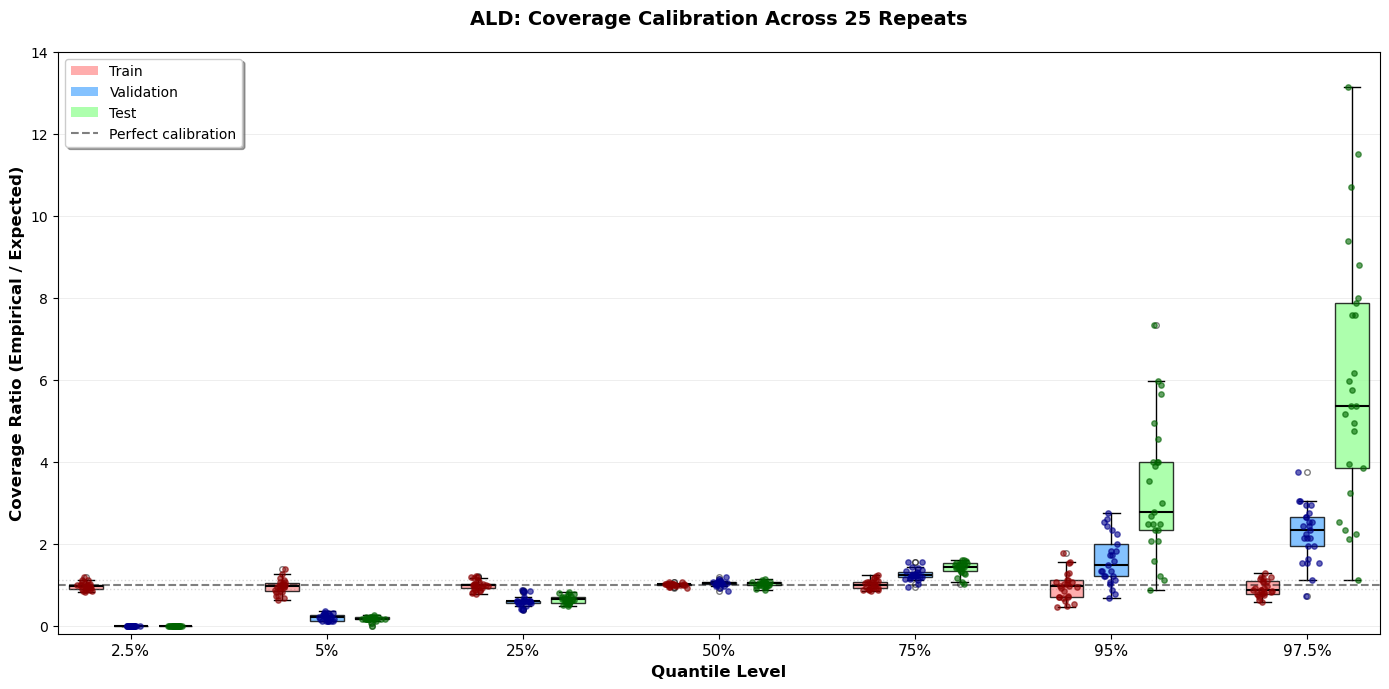

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_coverage_ratio_boxplot_all_repeats(all_train_results, levels, model_name="ALD", save_path=None):
    """
    Updated version with better x-axis formatting for quantiles
    """
    rng = np.random.default_rng(42)
    levels = sorted(levels)

    train_ratios_by_lvl, val_ratios_by_lvl, test_ratios_by_lvl = [], [], []
    labels = []

    for lvl in levels:
        reps = all_train_results.get(lvl, [])
        tr_list, va_list, te_list = [], [], []

        # expected tail coverage (extreme-tail convention)
        expected = lvl if lvl <= 0.5 else (1 - lvl)

        for rep in reps:
            # Direct access to metrics
            metrics = rep.get('metrics', {})

            # Get coverage ratios directly
            r_tr = metrics.get('train', {}).get('coverage_ratio', np.nan)
            r_va = metrics.get('val', {}).get('coverage_ratio', np.nan)
            r_te = metrics.get('test', {}).get('coverage_ratio', np.nan)

            # If coverage_ratio not available, calculate from actual_coverage
            if np.isnan(r_tr):
                cov_tr = metrics.get('train', {}).get('actual_coverage', np.nan)
                r_tr = cov_tr / expected if np.isfinite(cov_tr) and expected > 0 else np.nan
            if np.isnan(r_va):
                cov_va = metrics.get('val', {}).get('actual_coverage', np.nan)
                r_va = cov_va / expected if np.isfinite(cov_va) and expected > 0 else np.nan
            if np.isnan(r_te):
                cov_te = metrics.get('test', {}).get('actual_coverage', np.nan)
                r_te = cov_te / expected if np.isfinite(cov_te) and expected > 0 else np.nan

            tr_list.append(r_tr)
            va_list.append(r_va)
            te_list.append(r_te)

        train_ratios_by_lvl.append([r for r in tr_list if np.isfinite(r)])
        val_ratios_by_lvl.append([r for r in va_list if np.isfinite(r)])
        test_ratios_by_lvl.append([r for r in te_list if np.isfinite(r)])
        
        # Format labels based on quantile value
        if lvl == 0.025:
            labels.append("2.5%")
        elif lvl == 0.05:
            labels.append("5%")
        elif lvl == 0.975:
            labels.append("97.5%")
        else:
            labels.append(f"{int(lvl*100)}%")

    # x positions with more spacing
    K = len(levels)
    spacing = 3.5
    pos_tr = [i*spacing + 0.8 for i in range(K)]
    pos_va = [i*spacing + 1.6 for i in range(K)]
    pos_te = [i*spacing + 2.4 for i in range(K)]

    plt.figure(figsize=(14, 7))
    
    # boxplots
    bp1 = plt.boxplot(train_ratios_by_lvl, positions=pos_tr, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#ff9999", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))
    bp2 = plt.boxplot(val_ratios_by_lvl, positions=pos_va, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#66b3ff", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))
    bp3 = plt.boxplot(test_ratios_by_lvl, positions=pos_te, widths=0.6, patch_artist=True,
                      boxprops=dict(facecolor="#99ff99", alpha=0.8), 
                      medianprops=dict(color="black", linewidth=1.5),
                      flierprops=dict(marker='o', markersize=4, alpha=0.5))

    # overlay individual points with jitter
    for i in range(K):
        # train
        T = train_ratios_by_lvl[i]
        if T:
            x = rng.normal(pos_tr[i], 0.08, len(T))
            plt.scatter(x, T, s=15, color='darkred', alpha=0.6, zorder=3)
        # val
        V = val_ratios_by_lvl[i]
        if V:
            x = rng.normal(pos_va[i], 0.08, len(V))
            plt.scatter(x, V, s=15, color='darkblue', alpha=0.6, zorder=3)
        # test
        E = test_ratios_by_lvl[i]
        if E:
            x = rng.normal(pos_te[i], 0.08, len(E))
            plt.scatter(x, E, s=15, color='darkgreen', alpha=0.6, zorder=3)

    # perfect ratio line
    plt.axhline(1.0, linestyle='--', color='black', alpha=0.5, linewidth=1.5, label='Perfect calibration (ratio = 1.0)')
    
    # Add light horizontal lines at 0.9 and 1.1 for reference
    plt.axhline(0.9, linestyle=':', color='gray', alpha=0.3, linewidth=1)
    plt.axhline(1.1, linestyle=':', color='gray', alpha=0.3, linewidth=1)
    
    # y-limits
    all_vals = [v for grp in (train_ratios_by_lvl + val_ratios_by_lvl + test_ratios_by_lvl) for v in grp]
    if all_vals:
        y_min = -0.2
        y_max = 14.0
    else:
        y_min, y_max = 0.5, 1.5
    plt.ylim(y_min, y_max)

    # x-axis
    tick_pos = [(pos_tr[i] + pos_te[i]) / 2 for i in range(K)]
    plt.xticks(tick_pos, labels, fontsize=11)
    plt.xlabel('Quantile Level', fontsize=12, fontweight='bold')
    plt.ylabel('Coverage Ratio (Empirical / Expected)', fontsize=12, fontweight='bold')
    plt.title(f'{model_name}: Coverage Calibration Across 25 Repeats', fontsize=14, fontweight='bold', pad=20)
    
    # Legend
    legend_elements = [
        Patch(facecolor="#ff9999", alpha=0.8, label="Train"),
        Patch(facecolor="#66b3ff", alpha=0.8, label="Validation"),
        Patch(facecolor="#99ff99", alpha=0.8, label="Test"),
        plt.Line2D([0], [0], color='black', linestyle='--', alpha=0.5, linewidth=1.5, label='Perfect calibration')
    ]
    plt.legend(handles=legend_elements, loc='upper left', frameon=True, fontsize=10, 
               fancybox=True, shadow=True)
    
    plt.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Usage
levels = sorted(all_train_results.keys())
plot_coverage_ratio_boxplot_all_repeats(
    all_train_results=all_train_results,
    levels=levels,
    model_name="ALD",
    save_path="thesis_ald_coverage_ratio_boxplot.png"
)

In [104]:
from scipy import stats
import numpy as np

def kupiec_test(y_true, y_pred, alpha, tail='lower'):
    """
    Kupiec test for quantile prediction accuracy
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # Ensure same length
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    
    # Count violations
    if tail == 'lower':
        violations = np.sum(y_true <= y_pred)
    else:
        violations = np.sum(y_true > y_pred)
    
    n = violations
    T = len(y_true)
    p_hat = n / T
    
    # Expected violations
    if tail == 'lower':
        expected_rate = alpha
    else:
        expected_rate = 1 - alpha
    
    # Avoid log(0) issues
    if n == 0 or n == T:
        return {
            'statistic': np.inf,
            'p_value': 0.0,
            'violations': n,
            'expected': T * expected_rate,
            'reject': True,
            'message': 'Extreme case: no violations or all violations'
        }
    
    # Likelihood ratio statistic
    LR = -2 * np.log(
        (expected_rate**n * (1-expected_rate)**(T-n)) / 
        (p_hat**n * (1-p_hat)**(T-n))
    )
    
    # P-value from chi-squared distribution with 1 df
    p_value = 1 - stats.chi2.cdf(LR, df=1)
    
    # Reject null hypothesis if p-value < 0.05
    reject = p_value < 0.05
    
    return {
        'statistic': LR,
        'p_value': p_value,
        'violations': n,
        'expected': T * expected_rate,
        'empirical_rate': p_hat,
        'expected_rate': expected_rate,
        'reject': reject,
        'message': 'Reject: Model is miscalibrated' if reject else 'Fail to reject: Model is well-calibrated'
    }

# Run Kupiec tests for mixture model
def run_kupiec_tests_mixture(best_predictions, X_all, y_all):
    """Run Kupiec tests using your available data"""
    
    # Extract test data
    n_all = len(y_all)
    train_size = int(n_all * 0.7)
    val_size = int(n_all * 0.15)
    test_start_idx = train_size + val_size
    
    # Convert y_all to numpy
    if hasattr(y_all, 'cpu'):  # Check if it's a tensor
        y_all_np = y_all.cpu().numpy()
    else:
        y_all_np = np.array(y_all)
    
    y_test = y_all_np[test_start_idx:]
    
    # Get test predictions
    first_key = list(best_predictions.keys())[0]
    pred_length = len(best_predictions[first_key])
    
    print(f"Debug: y_test length = {len(y_test)}, prediction length = {pred_length}")
    
    test_predictions = {}
    if pred_length == n_all:
        # Full predictions
        for q in best_predictions.keys():
            test_predictions[q] = np.array(best_predictions[q])[test_start_idx:]
    else:
        # Already test only - ensure same length
        min_len = min(len(y_test), pred_length)
        y_test = y_test[:min_len]
        for q in best_predictions.keys():
            test_predictions[q] = np.array(best_predictions[q])[:min_len]
    
    print(f"Using {len(y_test)} test samples for Kupiec tests")
    
    # Run Kupiec tests
    print("\n" + "="*100)
    print("KUPIEC TEST RESULTS - MIXTURE MODEL")
    print("="*100)
    print("H0: Model is correctly calibrated (actual coverage = nominal coverage)")
    print("Reject if p-value < 0.05")
    print("-"*100)
    print(f"{'Quantile':<10} {'Violations':<12} {'Expected':<12} {'LR Stat':<12} {'P-value':<12} {'Result':<20}")
    print("-"*100)
    
    results = {}
    for q in sorted(test_predictions.keys()):
        tail = 'lower' if q <= 0.5 else 'upper'
        result = kupiec_test(y_test, test_predictions[q], q, tail)
        results[q] = result
        
        print(f"{q*100:>7.1f}% {result['violations']:>11} "
              f"{result['expected']:>11.1f} {result['statistic']:>11.3f} "
              f"{result['p_value']:>11.3f} {'REJECT' if result['reject'] else 'PASS':>20}")
    
    n_reject = sum(1 for r in results.values() if r['reject'])
    print("-"*100)
    print(f"Summary: {n_reject}/{len(results)} quantiles rejected (miscalibrated)")
    print("="*100)
    
    return results

# Run it
kupiec_results = run_kupiec_tests_mixture(best_predictions, X_all, y_all)

Debug: y_test length = 396, prediction length = 2630
Using 396 test samples for Kupiec tests

KUPIEC TEST RESULTS - MIXTURE MODEL
H0: Model is correctly calibrated (actual coverage = nominal coverage)
Reject if p-value < 0.05
----------------------------------------------------------------------------------------------------
Quantile   Violations   Expected     LR Stat      P-value      Result              
----------------------------------------------------------------------------------------------------
    2.5%           0         9.9         inf       0.000               REJECT
    5.0%           4        19.8      19.459       0.000               REJECT
   25.0%          81        99.0       4.561       0.033               REJECT
   50.0%         194       198.0       0.162       0.688                 PASS
   75.0%         104        99.0       0.333       0.564                 PASS
   95.0%          31        19.8       5.732       0.017               REJECT
   97.5%          11

In [194]:
def detailed_model_analysis(model, input_shape=(1, 3, 8)):
    """Provide detailed parameter analysis for a single model"""
    
    print("="*80)
    print("DETAILED MODEL PARAMETER ANALYSIS")
    print("="*80)
    
    # 1. Basic parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nTotal Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Non-trainable Parameters: {total_params - trainable_params:,}")
    
    # 2. Layer-by-layer breakdown with grouping
    print("\n" + "-"*80)
    print("LAYER-BY-LAYER PARAMETER BREAKDOWN")
    print("-"*80)
    print(f"{'Layer Name':<45} {'Shape':<20} {'Parameters':<15} {'Type':<15}")
    print("-"*80)
    
    # Group parameters by component
    lstm_params = []
    fc_params = []
    norm_params = []
    
    for name, param in model.named_parameters():
        param_info = {
            'name': name,
            'shape': str(param.shape),
            'count': param.numel(),
            'trainable': param.requires_grad
        }
        
        if 'lstm' in name and 'layer_norm' not in name:
            lstm_params.append(param_info)
        elif 'layer_norm' in name:
            norm_params.append(param_info)
        else:
            fc_params.append(param_info)
    
    # Print LSTM parameters
    if lstm_params:
        print("LSTM Layer:")
        for p in lstm_params:
            print(f"  {p['name']:<43} {p['shape']:<20} {p['count']:>14,} {'Trainable' if p['trainable'] else 'Non-trainable':<15}")
    
    # Print LayerNorm parameters
    if norm_params:
        print("\nLayerNorm Layers:")
        for p in norm_params:
            print(f"  {p['name']:<43} {p['shape']:<20} {p['count']:>14,} {'Trainable' if p['trainable'] else 'Non-trainable':<15}")
    
    # Print FC parameters
    if fc_params:
        print("\nFully Connected Layers:")
        for p in fc_params:
            print(f"  {p['name']:<43} {p['shape']:<20} {p['count']:>14,} {'Trainable' if p['trainable'] else 'Non-trainable':<15}")
    
    # 3. Architecture breakdown
    print("\n" + "-"*80)
    print("ARCHITECTURE BREAKDOWN")
    print("-"*80)
    
    # Analyze the sequential structure
    print("\nSequential Structure:")
    for i, (name, module) in enumerate(model.named_children()):
        print(f"\n{name}:")
        if hasattr(module, '__iter__'):
            for j, submodule in enumerate(module):
                params = sum(p.numel() for p in submodule.parameters())
                print(f"  [{j}] {submodule.__class__.__name__:<20} {params:>10,} params")
        else:
            params = sum(p.numel() for p in module.parameters())
            print(f"  {module.__class__.__name__:<20} {params:>10,} params")
    
    # 4. Parameter statistics by component
    print("\n" + "-"*80)
    print("PARAMETER COUNT BY COMPONENT")
    print("-"*80)
    
    # Calculate component-wise parameters
    lstm_total = sum(p['count'] for p in lstm_params)
    norm_total = sum(p['count'] for p in norm_params)
    fc_total = sum(p['count'] for p in fc_params)
    
    print(f"{'Component':<25} {'Parameters':<15} {'Percentage':<15}")
    print("-"*55)
    print(f"{'LSTM':<25} {lstm_total:>14,} {lstm_total/total_params*100:>13.1f}%")
    print(f"{'LayerNorm (all)':<25} {norm_total:>14,} {norm_total/total_params*100:>13.1f}%")
    print(f"{'Fully Connected':<25} {fc_total:>14,} {fc_total/total_params*100:>13.1f}%")
    print("-"*55)
    print(f"{'TOTAL':<25} {total_params:>14,} {100.0:>13.1f}%")
    
    # 5. Memory usage estimation
    print("\n" + "-"*80)
    print("MEMORY USAGE ESTIMATION")
    print("-"*80)
    
    # Parameters memory (assuming float32)
    param_memory = total_params * 4 / (1024**2)  # in MB
    print(f"Parameter Memory (float32): {param_memory:.2f} MB")
    print(f"Parameter Memory (float16): {param_memory/2:.2f} MB")
    
    # 6. Layer dimensions summary
    print("\n" + "-"*80)
    print("LAYER DIMENSIONS SUMMARY")
    print("-"*80)
    
    # Extract dimensions from config
    print(f"Input dimension: 8")
    print(f"LSTM hidden dimension: {model.lstm.hidden_size}")
    print(f"Number of LSTM layers: {model.lstm.num_layers}")
    
    # Extract FC layer dimensions
    fc_dims = []
    for module in model.fc:
        if isinstance(module, nn.Linear):
            fc_dims.append((module.in_features, module.out_features))
    
    print(f"FC layers: ", end="")
    prev_out = model.lstm.hidden_size
    for i, (in_dim, out_dim) in enumerate(fc_dims):
        print(f"{in_dim}→{out_dim}", end="")
        if i < len(fc_dims) - 1:
            print(" → ", end="")
    print()
    
    return total_params

# Run analysis for all unique architectures
print("="*80)
print("ANALYZING ALL UNIQUE ALD ARCHITECTURES")
print("="*80)

best_hyperparams = get_best_hyperparameters_from_tuning()

# Find unique architectures
unique_archs = {}
for tau, config in best_hyperparams.items():
    arch_key = (config['lstm_hidden_dim'], config['n_hidden1'], config['n_hidden2'])
    if arch_key not in unique_archs:
        unique_archs[arch_key] = {
            'config': config,
            'quantiles': []
        }
    unique_archs[arch_key]['quantiles'].append(tau)

# Analyze each unique architecture
for i, (arch_key, arch_info) in enumerate(unique_archs.items()):
    lstm_dim, h1, h2 = arch_key
    config = arch_info['config'].copy()
    config["input_dim"] = 8
    config["tau"] = arch_info['quantiles'][0]
    
    print(f"\n{'='*80}")
    print(f"Architecture {i+1}: LSTM({lstm_dim})-FC({h1},{h2})")
    print(f"Used for quantiles: {', '.join([f'{q:.3f}' for q in arch_info['quantiles']])}")
    print(f"{'='*80}")
    
    model = AsymmetricLaplaceQuantile(config)
    total_params = detailed_model_analysis(model, input_shape=(1, 3, 8))
    
    if i < len(unique_archs) - 1:
        print("\n" + "="*80)

# Summary table
print("\n" + "="*80)
print("SUMMARY: ALD MODEL ARCHITECTURES")
print("="*80)
print(f"{'Architecture':<25} {'Parameters':<15} {'Quantiles':<40}")
print("-"*80)

for arch_key, arch_info in unique_archs.items():
    lstm_dim, h1, h2 = arch_key
    config = arch_info['config'].copy()
    config["input_dim"] = 8
    config["tau"] = arch_info['quantiles'][0]
    
    model = AsymmetricLaplaceQuantile(config)
    total_params = sum(p.numel() for p in model.parameters())
    
    arch_str = f"LSTM({lstm_dim})-FC({h1},{h2})"
    quant_str = ', '.join([f'{q:.3f}' for q in arch_info['quantiles']])
    print(f"{arch_str:<25} {total_params:>14,} {quant_str:<40}")

print("="*80)

ANALYZING ALL UNIQUE ALD ARCHITECTURES

Architecture 1: LSTM(102)-FC(16,41)
Used for quantiles: 0.025, 0.050, 0.950, 0.975
DETAILED MODEL PARAMETER ANALYSIS

Total Parameters: 48,319
Trainable Parameters: 48,319
Non-trainable Parameters: 0

--------------------------------------------------------------------------------
LAYER-BY-LAYER PARAMETER BREAKDOWN
--------------------------------------------------------------------------------
Layer Name                                    Shape                Parameters      Type           
--------------------------------------------------------------------------------
LSTM Layer:
  lstm.weight_ih_l0                           torch.Size([408, 8])          3,264 Trainable      
  lstm.weight_hh_l0                           torch.Size([408, 102])         41,616 Trainable      
  lstm.bias_ih_l0                             torch.Size([408])               408 Trainable      
  lstm.bias_hh_l0                             torch.Size([408])           